# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go

In [2]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')

ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'latin-1')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [5]:
croot_data = pd.DataFrame()

for i in range(2007, 2021):
    k = retrieveCfbDataFile('recruiting',i)
    croot_data = croot_data.append(k, sort=False)

def calc_rolling_avg(frame, y):
    return frame[(frame.year == (y-3))| (frame.year == (y-2)) | (frame.year == (y-1)) | (frame.year == y)].rating.mean()
def calculate_fcs_talent(year):
    return croot_data[(croot_data.year == (yr-3))| (croot_data.year == (yr-2)) | (croot_data.year == (yr-1)) | (croot_data.year == yr)].rating.quantile(.02)
def calculate_roster_talent(team, year):
    team_slice = croot_data[(croot_data.committedTo == team)]
    if (len(team_slice) == 0):
        return calculate_fcs_talent(year)
    return calc_rolling_avg(team_slice ,year)
# calculate_roster_talent("Alabama", 2020)
print(f"Total Croots: {len(croot_data)}")

Total Croots: 44156


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

Clean Drives: 170795


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [8]:
off_play_types

['Pass Incompletion',
 'Pass Completion',
 'Rush',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [9]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)

In [10]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,26,35,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449


In [11]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [12]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP,play_explosive,play_successful
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000,False,False
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000,False,False
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253,False,False
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460,True,True
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449,False,True


In [13]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

def determine_kick_return(row, play_value):
    if "touchback" in row.PlayText:
        return 25
    else:
        return play_value
    
def determine_punt_return(row, play_value):
    if "touchback" in row.PlayText:
        return 20
    else:
        return play_value

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = tmp.values
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: determine_kick_return(x, kickoff_plays.yards_gained[x.Index]),axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = pt_tmp.values
        punt_distance["PlayText"] = punt_distance.apply(lambda x: punt_plays.play_text[x.Index],axis=1)
        punt_distance["Return"] = punt_distance.apply(lambda x: determine_punt_return(x, punt_plays.yards_gained[x.Index]),axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    #return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.0,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,0.0,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [14]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.142022,5.050452,5.386628,4.46,5.017309,5.070568,0.141137
1,Virginia Tech,4.857978,4.949548,4.613372,5.54,4.982691,4.929432,-0.141137


In [15]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if (('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv"))):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

stored_game_boxes.Team = stored_game_boxes.Team.apply(lambda x: "San Jose State" if (x == "San JosÃÂÃÂ© State") else x)
if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 4504 box score groups by GameID.
[1/4504] Updating 5FR Margin for game_id 322430238...
[1/4504] Updated 5FR Margin for game_id 322430238.
[2/4504] Updating 5FR Margin for game_id 322430242...
[2/4504] Updated 5FR Margin for game_id 322430242.
[3/4504] Updating 5FR Margin for game_id 322432006...
[3/4504] Updated 5FR Margin for game_id 322432006.
[4/4504] Updating 5FR Margin for game_id 322432050...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[4/4504] Updated 5FR Margin for game_id 322432050.
[5/4504] Updating 5FR Margin for game_id 322432439...
[5/4504] Updated 5FR Margin for game_id 322432439.
[6/4504] Updating 5FR Margin for game_id 322440024...
[6/4504] Updated 5FR Margin for game_id 322440024.
[7/4504] Updating 5FR Margin for game_id 322442633...
[7/4504] Updated 5FR Margin for game_id 322442633.
[8/4504] Updating 5FR Margin for game_id 322450002...
[8/4504] Updated 5FR Margin for game_id 322450002.
[9/4504] Updating 5FR Margin for game_id 322450005...
[9/4504] Updated 5FR Margin for game_id 322450005.
[10/4504] Updating 5FR Margin for game_id 322450012...
[10/4504] Updated 5FR Margin for game_id 322450012.
[11/4504] Updating 5FR Margin for game_id 322450025...
[11/4504] Updated 5FR Margin for game_id 322450025.
[12/4504] Updating 5FR Margin for game_id 322450030...
[12/4504] Updated 5FR Margin for game_id 322450030.
[13/4504] Updating 5FR Margin for game_id 322450038...
[13/4504] Updated 5FR Margin for game_id 3224500

[90/4504] Updated 5FR Margin for game_id 322590194.
[91/4504] Updating 5FR Margin for game_id 322590197...
[91/4504] Updated 5FR Margin for game_id 322590197.
[92/4504] Updating 5FR Margin for game_id 322590213...
[92/4504] Updated 5FR Margin for game_id 322590213.
[93/4504] Updating 5FR Margin for game_id 322590221...
[93/4504] Updated 5FR Margin for game_id 322590221.
[94/4504] Updating 5FR Margin for game_id 322590235...
[94/4504] Updated 5FR Margin for game_id 322590235.
[95/4504] Updating 5FR Margin for game_id 322590254...
[95/4504] Updated 5FR Margin for game_id 322590254.
[96/4504] Updating 5FR Margin for game_id 322590275...
[96/4504] Updated 5FR Margin for game_id 322590275.
[97/4504] Updating 5FR Margin for game_id 322590276...
[97/4504] Updated 5FR Margin for game_id 322590276.
[98/4504] Updating 5FR Margin for game_id 322590278...
[98/4504] Updated 5FR Margin for game_id 322590278.
[99/4504] Updating 5FR Margin for game_id 322590349...
[99/4504] Updated 5FR Margin for game

[171/4504] Updated 5FR Margin for game_id 322732132.
[172/4504] Updating 5FR Margin for game_id 322732226...
[172/4504] Updated 5FR Margin for game_id 322732226.
[173/4504] Updating 5FR Margin for game_id 322732294...
[173/4504] Updated 5FR Margin for game_id 322732294.
[174/4504] Updating 5FR Margin for game_id 322732309...
[174/4504] Updated 5FR Margin for game_id 322732309.
[175/4504] Updating 5FR Margin for game_id 322732390...
[175/4504] Updated 5FR Margin for game_id 322732390.
[176/4504] Updating 5FR Margin for game_id 322732509...
[176/4504] Updated 5FR Margin for game_id 322732509.
[177/4504] Updating 5FR Margin for game_id 322732567...
[177/4504] Updated 5FR Margin for game_id 322732567.
[178/4504] Updating 5FR Margin for game_id 322732572...
[178/4504] Updated 5FR Margin for game_id 322732572.
[179/4504] Updating 5FR Margin for game_id 322732711...
[179/4504] Updated 5FR Margin for game_id 322732711.
[180/4504] Updating 5FR Margin for game_id 322780254...
[180/4504] Updated 

[254/4504] Updated 5FR Margin for game_id 322872116.
[255/4504] Updating 5FR Margin for game_id 322872229...
[255/4504] Updated 5FR Margin for game_id 322872229.
[256/4504] Updating 5FR Margin for game_id 322872305...
[256/4504] Updated 5FR Margin for game_id 322872305.
[257/4504] Updating 5FR Margin for game_id 322872348...
[257/4504] Updated 5FR Margin for game_id 322872348.
[258/4504] Updating 5FR Margin for game_id 322872433...
[258/4504] Updated 5FR Margin for game_id 322872433.
[259/4504] Updating 5FR Margin for game_id 322872459...
[259/4504] Updated 5FR Margin for game_id 322872459.
[260/4504] Updating 5FR Margin for game_id 322872509...
[260/4504] Updated 5FR Margin for game_id 322872509.
[261/4504] Updating 5FR Margin for game_id 322872641...
[261/4504] Updated 5FR Margin for game_id 322872641.
[262/4504] Updating 5FR Margin for game_id 322872751...
[262/4504] Updated 5FR Margin for game_id 322872751.
[263/4504] Updating 5FR Margin for game_id 322900249...
[263/4504] Updated 

[330/4504] Updated 5FR Margin for game_id 323010164.
[331/4504] Updating 5FR Margin for game_id 323010166...
[331/4504] Updated 5FR Margin for game_id 323010166.
[332/4504] Updating 5FR Margin for game_id 323010167...
[332/4504] Updated 5FR Margin for game_id 323010167.
[333/4504] Updating 5FR Margin for game_id 323010189...
[333/4504] Updated 5FR Margin for game_id 323010189.
[334/4504] Updating 5FR Margin for game_id 323010193...
[334/4504] Updated 5FR Margin for game_id 323010193.
[335/4504] Updating 5FR Margin for game_id 323010197...
[335/4504] Updated 5FR Margin for game_id 323010197.
[336/4504] Updating 5FR Margin for game_id 323010201...
[336/4504] Updated 5FR Margin for game_id 323010201.
[337/4504] Updating 5FR Margin for game_id 323010213...
[337/4504] Updated 5FR Margin for game_id 323010213.
[338/4504] Updating 5FR Margin for game_id 323010221...
[338/4504] Updated 5FR Margin for game_id 323010221.
[339/4504] Updating 5FR Margin for game_id 323010238...
[339/4504] Updated 

[410/4504] Updated 5FR Margin for game_id 323150183.
[411/4504] Updating 5FR Margin for game_id 323150197...
[411/4504] Updated 5FR Margin for game_id 323150197.
[412/4504] Updating 5FR Margin for game_id 323150201...
[412/4504] Updated 5FR Margin for game_id 323150201.
[413/4504] Updating 5FR Margin for game_id 323150218...
[413/4504] Updated 5FR Margin for game_id 323150218.
[414/4504] Updating 5FR Margin for game_id 323150228...
[414/4504] Updated 5FR Margin for game_id 323150228.
[415/4504] Updating 5FR Margin for game_id 323150248...
[415/4504] Updated 5FR Margin for game_id 323150248.
[416/4504] Updating 5FR Margin for game_id 323150249...
[416/4504] Updated 5FR Margin for game_id 323150249.
[417/4504] Updating 5FR Margin for game_id 323150251...
[417/4504] Updated 5FR Margin for game_id 323150251.
[418/4504] Updating 5FR Margin for game_id 323150258...
[418/4504] Updated 5FR Margin for game_id 323150258.
[419/4504] Updating 5FR Margin for game_id 323150264...
[419/4504] Updated 

[488/4504] Updated 5FR Margin for game_id 323290036.
[489/4504] Updating 5FR Margin for game_id 323290061...
[489/4504] Updated 5FR Margin for game_id 323290061.
[490/4504] Updating 5FR Margin for game_id 323290097...
[490/4504] Updated 5FR Margin for game_id 323290097.
[491/4504] Updating 5FR Margin for game_id 323290135...
[491/4504] Updated 5FR Margin for game_id 323290135.
[492/4504] Updating 5FR Margin for game_id 323290145...
[492/4504] Updated 5FR Margin for game_id 323290145.
[493/4504] Updating 5FR Margin for game_id 323290150...
[493/4504] Updated 5FR Margin for game_id 323290150.
[494/4504] Updating 5FR Margin for game_id 323290153...
[494/4504] Updated 5FR Margin for game_id 323290153.
[495/4504] Updating 5FR Margin for game_id 323290154...
[495/4504] Updated 5FR Margin for game_id 323290154.
[496/4504] Updating 5FR Margin for game_id 323290166...
[496/4504] Updated 5FR Margin for game_id 323290166.
[497/4504] Updating 5FR Margin for game_id 323290194...
[497/4504] Updated 

[569/4504] Updated 5FR Margin for game_id 332500077.
[570/4504] Updating 5FR Margin for game_id 332500099...
[570/4504] Updated 5FR Margin for game_id 332500099.
[571/4504] Updating 5FR Margin for game_id 332500120...
[571/4504] Updated 5FR Margin for game_id 332500120.
[572/4504] Updating 5FR Margin for game_id 332500142...
[572/4504] Updated 5FR Margin for game_id 332500142.
[573/4504] Updating 5FR Margin for game_id 332500153...
[573/4504] Updated 5FR Margin for game_id 332500153.
[574/4504] Updating 5FR Margin for game_id 332500158...
[574/4504] Updated 5FR Margin for game_id 332500158.
[575/4504] Updating 5FR Margin for game_id 332500166...
[575/4504] Updated 5FR Margin for game_id 332500166.
[576/4504] Updating 5FR Margin for game_id 332500194...
[576/4504] Updated 5FR Margin for game_id 332500194.
[577/4504] Updating 5FR Margin for game_id 332500195...
[577/4504] Updated 5FR Margin for game_id 332500195.
[578/4504] Updating 5FR Margin for game_id 332500201...
[578/4504] Updated 

[645/4504] Updated 5FR Margin for game_id 332640235.
[646/4504] Updating 5FR Margin for game_id 332640239...
[646/4504] Updated 5FR Margin for game_id 332640239.
[647/4504] Updating 5FR Margin for game_id 332640242...
[647/4504] Updated 5FR Margin for game_id 332640242.
[648/4504] Updating 5FR Margin for game_id 332640245...
[648/4504] Updated 5FR Margin for game_id 332640245.
[649/4504] Updating 5FR Margin for game_id 332640251...
[649/4504] Updated 5FR Margin for game_id 332640251.
[650/4504] Updating 5FR Margin for game_id 332640252...
[650/4504] Updated 5FR Margin for game_id 332640252.
[651/4504] Updating 5FR Margin for game_id 332640259...
[651/4504] Updated 5FR Margin for game_id 332640259.
[652/4504] Updating 5FR Margin for game_id 332640275...
[652/4504] Updated 5FR Margin for game_id 332640275.
[653/4504] Updating 5FR Margin for game_id 332640349...
[653/4504] Updated 5FR Margin for game_id 332640349.
[654/4504] Updating 5FR Margin for game_id 332642005...
[654/4504] Updated 

[725/4504] Updated 5FR Margin for game_id 332780201.
[726/4504] Updating 5FR Margin for game_id 332780202...
[726/4504] Updated 5FR Margin for game_id 332780202.
[727/4504] Updating 5FR Margin for game_id 332780235...
[727/4504] Updated 5FR Margin for game_id 332780235.
[728/4504] Updating 5FR Margin for game_id 332780238...
[728/4504] Updated 5FR Margin for game_id 332780238.
[729/4504] Updating 5FR Margin for game_id 332780258...
[729/4504] Updated 5FR Margin for game_id 332780258.
[730/4504] Updating 5FR Margin for game_id 332780259...
[730/4504] Updated 5FR Margin for game_id 332780259.
[731/4504] Updating 5FR Margin for game_id 332780276...
[731/4504] Updated 5FR Margin for game_id 332780276.
[732/4504] Updating 5FR Margin for game_id 332780309...
[732/4504] Updated 5FR Margin for game_id 332780309.
[733/4504] Updating 5FR Margin for game_id 332780344...
[733/4504] Updated 5FR Margin for game_id 332780344.
[734/4504] Updating 5FR Margin for game_id 332782006...
[734/4504] Updated 

[806/4504] Updated 5FR Margin for game_id 332920258.
[807/4504] Updating 5FR Margin for game_id 332920277...
[807/4504] Updated 5FR Margin for game_id 332920277.
[808/4504] Updating 5FR Margin for game_id 332920278...
[808/4504] Updated 5FR Margin for game_id 332920278.
[809/4504] Updating 5FR Margin for game_id 332920326...
[809/4504] Updated 5FR Margin for game_id 332920326.
[810/4504] Updating 5FR Margin for game_id 332922117...
[810/4504] Updated 5FR Margin for game_id 332922117.
[811/4504] Updating 5FR Margin for game_id 332922305...
[811/4504] Updated 5FR Margin for game_id 332922305.
[812/4504] Updating 5FR Margin for game_id 332922348...
[812/4504] Updated 5FR Margin for game_id 332922348.
[813/4504] Updating 5FR Margin for game_id 332922483...
[813/4504] Updated 5FR Margin for game_id 332922483.
[814/4504] Updating 5FR Margin for game_id 332922633...
[814/4504] Updated 5FR Margin for game_id 332922633.
[815/4504] Updating 5FR Margin for game_id 332922711...
[815/4504] Updated 

[889/4504] Updated 5FR Margin for game_id 333062005.
[890/4504] Updating 5FR Margin for game_id 333062226...
[890/4504] Updated 5FR Margin for game_id 333062226.
[891/4504] Updating 5FR Margin for game_id 333062229...
[891/4504] Updated 5FR Margin for game_id 333062229.
[892/4504] Updating 5FR Margin for game_id 333062294...
[892/4504] Updated 5FR Margin for game_id 333062294.
[893/4504] Updating 5FR Margin for game_id 333062306...
[893/4504] Updated 5FR Margin for game_id 333062306.
[894/4504] Updating 5FR Margin for game_id 333062439...
[894/4504] Updated 5FR Margin for game_id 333062439.
[895/4504] Updating 5FR Margin for game_id 333062579...
[895/4504] Updated 5FR Margin for game_id 333062579.
[896/4504] Updating 5FR Margin for game_id 333062628...
[896/4504] Updated 5FR Margin for game_id 333062628.
[897/4504] Updating 5FR Margin for game_id 333062641...
[897/4504] Updated 5FR Margin for game_id 333062641.
[898/4504] Updating 5FR Margin for game_id 333090193...
[898/4504] Updated 

[967/4504] Updated 5FR Margin for game_id 333202426.
[968/4504] Updating 5FR Margin for game_id 333202440...
[968/4504] Updated 5FR Margin for game_id 333202440.
[969/4504] Updating 5FR Margin for game_id 333202579...
[969/4504] Updated 5FR Margin for game_id 333202579.
[970/4504] Updating 5FR Margin for game_id 333202638...
[970/4504] Updated 5FR Margin for game_id 333202638.
[971/4504] Updating 5FR Margin for game_id 333202711...
[971/4504] Updated 5FR Margin for game_id 333202711.
[972/4504] Updating 5FR Margin for game_id 333230193...
[972/4504] Updated 5FR Margin for game_id 333230193.
[973/4504] Updating 5FR Margin for game_id 333230195...
[973/4504] Updated 5FR Margin for game_id 333230195.
[974/4504] Updating 5FR Margin for game_id 333242649...
[974/4504] Updated 5FR Margin for game_id 333242649.
[975/4504] Updating 5FR Margin for game_id 333250005...
[975/4504] Updated 5FR Margin for game_id 333250005.
[976/4504] Updating 5FR Margin for game_id 333270006...
[976/4504] Updated 

[1044/4504] Updated 5FR Margin for game_id 333340328.
[1045/4504] Updating 5FR Margin for game_id 333342247...
[1045/4504] Updated 5FR Margin for game_id 333342247.
[1046/4504] Updating 5FR Margin for game_id 333342305...
[1046/4504] Updated 5FR Margin for game_id 333342305.
[1047/4504] Updating 5FR Margin for game_id 333342393...
[1047/4504] Updated 5FR Margin for game_id 333342393.
[1048/4504] Updating 5FR Margin for game_id 333342439...
[1048/4504] Updated 5FR Margin for game_id 333342439.
[1049/4504] Updating 5FR Margin for game_id 333342440...
[1049/4504] Updated 5FR Margin for game_id 333342440.
[1050/4504] Updating 5FR Margin for game_id 333342628...
[1050/4504] Updated 5FR Margin for game_id 333342628.
[1051/4504] Updating 5FR Margin for game_id 333342636...
[1051/4504] Updated 5FR Margin for game_id 333342636.
[1052/4504] Updating 5FR Margin for game_id 333392132...
[1052/4504] Updated 5FR Margin for game_id 333392132.
[1053/4504] Updating 5FR Margin for game_id 333402459...
[

[1122/4504] Updated 5FR Margin for game_id 400547735.
[1123/4504] Updating 5FR Margin for game_id 400547736...
[1123/4504] Updated 5FR Margin for game_id 400547736.
[1124/4504] Updating 5FR Margin for game_id 400547737...
[1124/4504] Updated 5FR Margin for game_id 400547737.
[1125/4504] Updating 5FR Margin for game_id 400547738...
[1125/4504] Updated 5FR Margin for game_id 400547738.
[1126/4504] Updating 5FR Margin for game_id 400547739...
[1126/4504] Updated 5FR Margin for game_id 400547739.
[1127/4504] Updating 5FR Margin for game_id 400547740...
[1127/4504] Updated 5FR Margin for game_id 400547740.
[1128/4504] Updating 5FR Margin for game_id 400547742...
[1128/4504] Updated 5FR Margin for game_id 400547742.
[1129/4504] Updating 5FR Margin for game_id 400547743...
[1129/4504] Updated 5FR Margin for game_id 400547743.
[1130/4504] Updating 5FR Margin for game_id 400547744...
[1130/4504] Updated 5FR Margin for game_id 400547744.
[1131/4504] Updating 5FR Margin for game_id 400547745...
[

[1197/4504] Updated 5FR Margin for game_id 400547846.
[1198/4504] Updating 5FR Margin for game_id 400547848...
[1198/4504] Updated 5FR Margin for game_id 400547848.
[1199/4504] Updating 5FR Margin for game_id 400547849...
[1199/4504] Updated 5FR Margin for game_id 400547849.
[1200/4504] Updating 5FR Margin for game_id 400547850...
[1200/4504] Updated 5FR Margin for game_id 400547850.
[1201/4504] Updating 5FR Margin for game_id 400547851...
[1201/4504] Updated 5FR Margin for game_id 400547851.
[1202/4504] Updating 5FR Margin for game_id 400547852...
[1202/4504] Updated 5FR Margin for game_id 400547852.
[1203/4504] Updating 5FR Margin for game_id 400547853...
[1203/4504] Updated 5FR Margin for game_id 400547853.
[1204/4504] Updating 5FR Margin for game_id 400547855...
[1204/4504] Updated 5FR Margin for game_id 400547855.
[1205/4504] Updating 5FR Margin for game_id 400547856...
[1205/4504] Updated 5FR Margin for game_id 400547856.
[1206/4504] Updating 5FR Margin for game_id 400547858...
[

[1279/4504] Updated 5FR Margin for game_id 400547955.
[1280/4504] Updating 5FR Margin for game_id 400547956...
[1280/4504] Updated 5FR Margin for game_id 400547956.
[1281/4504] Updating 5FR Margin for game_id 400547957...
[1281/4504] Updated 5FR Margin for game_id 400547957.
[1282/4504] Updating 5FR Margin for game_id 400547958...
[1282/4504] Updated 5FR Margin for game_id 400547958.
[1283/4504] Updating 5FR Margin for game_id 400547959...
[1283/4504] Updated 5FR Margin for game_id 400547959.
[1284/4504] Updating 5FR Margin for game_id 400547961...
[1284/4504] Updated 5FR Margin for game_id 400547961.
[1285/4504] Updating 5FR Margin for game_id 400547963...
[1285/4504] Updated 5FR Margin for game_id 400547963.
[1286/4504] Updating 5FR Margin for game_id 400547964...
[1286/4504] Updated 5FR Margin for game_id 400547964.
[1287/4504] Updating 5FR Margin for game_id 400547965...
[1287/4504] Updated 5FR Margin for game_id 400547965.
[1288/4504] Updating 5FR Margin for game_id 400547966...
[

[1360/4504] Updated 5FR Margin for game_id 400548085.
[1361/4504] Updating 5FR Margin for game_id 400548086...
[1361/4504] Updated 5FR Margin for game_id 400548086.
[1362/4504] Updating 5FR Margin for game_id 400548087...
[1362/4504] Updated 5FR Margin for game_id 400548087.
[1363/4504] Updating 5FR Margin for game_id 400548088...
[1363/4504] Updated 5FR Margin for game_id 400548088.
[1364/4504] Updating 5FR Margin for game_id 400548089...
[1364/4504] Updated 5FR Margin for game_id 400548089.
[1365/4504] Updating 5FR Margin for game_id 400548097...
[1365/4504] Updated 5FR Margin for game_id 400548097.
[1366/4504] Updating 5FR Margin for game_id 400548099...
[1366/4504] Updated 5FR Margin for game_id 400548099.
[1367/4504] Updating 5FR Margin for game_id 400548101...
[1367/4504] Updated 5FR Margin for game_id 400548101.
[1368/4504] Updating 5FR Margin for game_id 400548102...
[1368/4504] Updated 5FR Margin for game_id 400548102.
[1369/4504] Updating 5FR Margin for game_id 400548103...
[

[1435/4504] Updated 5FR Margin for game_id 400548206.
[1436/4504] Updating 5FR Margin for game_id 400548207...
[1436/4504] Updated 5FR Margin for game_id 400548207.
[1437/4504] Updating 5FR Margin for game_id 400548208...
[1437/4504] Updated 5FR Margin for game_id 400548208.
[1438/4504] Updating 5FR Margin for game_id 400548210...
[1438/4504] Updated 5FR Margin for game_id 400548210.
[1439/4504] Updating 5FR Margin for game_id 400548212...
[1439/4504] Updated 5FR Margin for game_id 400548212.
[1440/4504] Updating 5FR Margin for game_id 400548213...
[1440/4504] Updated 5FR Margin for game_id 400548213.
[1441/4504] Updating 5FR Margin for game_id 400548214...
[1441/4504] Updated 5FR Margin for game_id 400548214.
[1442/4504] Updating 5FR Margin for game_id 400548215...
[1442/4504] Updated 5FR Margin for game_id 400548215.
[1443/4504] Updating 5FR Margin for game_id 400548216...
[1443/4504] Updated 5FR Margin for game_id 400548216.
[1444/4504] Updating 5FR Margin for game_id 400548217...
[

[1510/4504] Updated 5FR Margin for game_id 400548316.
[1511/4504] Updating 5FR Margin for game_id 400548317...
[1511/4504] Updated 5FR Margin for game_id 400548317.
[1512/4504] Updating 5FR Margin for game_id 400548318...
[1512/4504] Updated 5FR Margin for game_id 400548318.
[1513/4504] Updating 5FR Margin for game_id 400548319...
[1513/4504] Updated 5FR Margin for game_id 400548319.
[1514/4504] Updating 5FR Margin for game_id 400548322...
[1514/4504] Updated 5FR Margin for game_id 400548322.
[1515/4504] Updating 5FR Margin for game_id 400548323...
[1515/4504] Updated 5FR Margin for game_id 400548323.
[1516/4504] Updating 5FR Margin for game_id 400548324...
[1516/4504] Updated 5FR Margin for game_id 400548324.
[1517/4504] Updating 5FR Margin for game_id 400548326...
[1517/4504] Updated 5FR Margin for game_id 400548326.
[1518/4504] Updating 5FR Margin for game_id 400548327...
[1518/4504] Updated 5FR Margin for game_id 400548327.
[1519/4504] Updating 5FR Margin for game_id 400548332...
[

[1585/4504] Updated 5FR Margin for game_id 400550749.
[1586/4504] Updating 5FR Margin for game_id 400603827...
[1586/4504] Updated 5FR Margin for game_id 400603827.
[1587/4504] Updating 5FR Margin for game_id 400603829...
[1587/4504] Updated 5FR Margin for game_id 400603829.
[1588/4504] Updating 5FR Margin for game_id 400603832...
[1588/4504] Updated 5FR Margin for game_id 400603832.
[1589/4504] Updating 5FR Margin for game_id 400603836...
[1589/4504] Updated 5FR Margin for game_id 400603836.
[1590/4504] Updating 5FR Margin for game_id 400603838...
[1590/4504] Updated 5FR Margin for game_id 400603838.
[1591/4504] Updating 5FR Margin for game_id 400603839...
[1591/4504] Updated 5FR Margin for game_id 400603839.
[1592/4504] Updating 5FR Margin for game_id 400603841...
[1592/4504] Updated 5FR Margin for game_id 400603841.
[1593/4504] Updating 5FR Margin for game_id 400603842...
[1593/4504] Updated 5FR Margin for game_id 400603842.
[1594/4504] Updating 5FR Margin for game_id 400603843...
[

[1660/4504] Updated 5FR Margin for game_id 400603931.
[1661/4504] Updating 5FR Margin for game_id 400603932...
[1661/4504] Updated 5FR Margin for game_id 400603932.
[1662/4504] Updating 5FR Margin for game_id 400603933...
[1662/4504] Updated 5FR Margin for game_id 400603933.
[1663/4504] Updating 5FR Margin for game_id 400603934...
[1663/4504] Updated 5FR Margin for game_id 400603934.
[1664/4504] Updating 5FR Margin for game_id 400603937...
[1664/4504] Updated 5FR Margin for game_id 400603937.
[1665/4504] Updating 5FR Margin for game_id 400609055...
[1665/4504] Updated 5FR Margin for game_id 400609055.
[1666/4504] Updating 5FR Margin for game_id 400609076...
[1666/4504] Updated 5FR Margin for game_id 400609076.
[1667/4504] Updating 5FR Margin for game_id 400609077...
[1667/4504] Updated 5FR Margin for game_id 400609077.
[1668/4504] Updating 5FR Margin for game_id 400609096...
[1668/4504] Updated 5FR Margin for game_id 400609096.
[1669/4504] Updating 5FR Margin for game_id 400609098...
[

[1735/4504] Updated 5FR Margin for game_id 400756977.
[1736/4504] Updating 5FR Margin for game_id 400756978...
[1736/4504] Updated 5FR Margin for game_id 400756978.
[1737/4504] Updating 5FR Margin for game_id 400756979...
[1737/4504] Updated 5FR Margin for game_id 400756979.
[1738/4504] Updating 5FR Margin for game_id 400756981...
[1738/4504] Updated 5FR Margin for game_id 400756981.
[1739/4504] Updating 5FR Margin for game_id 400756982...
[1739/4504] Updated 5FR Margin for game_id 400756982.
[1740/4504] Updating 5FR Margin for game_id 400756983...
[1740/4504] Updated 5FR Margin for game_id 400756983.
[1741/4504] Updating 5FR Margin for game_id 400756984...
[1741/4504] Updated 5FR Margin for game_id 400756984.
[1742/4504] Updating 5FR Margin for game_id 400756985...
[1742/4504] Updated 5FR Margin for game_id 400756985.
[1743/4504] Updating 5FR Margin for game_id 400756986...
[1743/4504] Updated 5FR Margin for game_id 400756986.
[1744/4504] Updating 5FR Margin for game_id 400756987...
[

[1810/4504] Updated 5FR Margin for game_id 400760497.
[1811/4504] Updating 5FR Margin for game_id 400760498...
[1811/4504] Updated 5FR Margin for game_id 400760498.
[1812/4504] Updating 5FR Margin for game_id 400760500...
[1812/4504] Updated 5FR Margin for game_id 400760500.
[1813/4504] Updating 5FR Margin for game_id 400763398...
[1813/4504] Updated 5FR Margin for game_id 400763398.
[1814/4504] Updating 5FR Margin for game_id 400763399...
[1814/4504] Updated 5FR Margin for game_id 400763399.
[1815/4504] Updating 5FR Margin for game_id 400763403...
[1815/4504] Updated 5FR Margin for game_id 400763403.
[1816/4504] Updating 5FR Margin for game_id 400763404...
[1816/4504] Updated 5FR Margin for game_id 400763404.
[1817/4504] Updating 5FR Margin for game_id 400763407...
[1817/4504] Updated 5FR Margin for game_id 400763407.
[1818/4504] Updating 5FR Margin for game_id 400763409...
[1818/4504] Updated 5FR Margin for game_id 400763409.
[1819/4504] Updating 5FR Margin for game_id 400763410...
[

[1888/4504] Updated 5FR Margin for game_id 400763529.
[1889/4504] Updating 5FR Margin for game_id 400763530...
[1889/4504] Updated 5FR Margin for game_id 400763530.
[1890/4504] Updating 5FR Margin for game_id 400763531...
[1890/4504] Updated 5FR Margin for game_id 400763531.
[1891/4504] Updating 5FR Margin for game_id 400763532...
[1891/4504] Updated 5FR Margin for game_id 400763532.
[1892/4504] Updating 5FR Margin for game_id 400763534...
[1892/4504] Updated 5FR Margin for game_id 400763534.
[1893/4504] Updating 5FR Margin for game_id 400763536...
[1893/4504] Updated 5FR Margin for game_id 400763536.
[1894/4504] Updating 5FR Margin for game_id 400763537...
[1894/4504] Updated 5FR Margin for game_id 400763537.
[1895/4504] Updating 5FR Margin for game_id 400763538...
[1895/4504] Updated 5FR Margin for game_id 400763538.
[1896/4504] Updating 5FR Margin for game_id 400763539...
[1896/4504] Updated 5FR Margin for game_id 400763539.
[1897/4504] Updating 5FR Margin for game_id 400763540...
[

[1969/4504] Updated 5FR Margin for game_id 400763651.
[1970/4504] Updating 5FR Margin for game_id 400763653...
[1970/4504] Updated 5FR Margin for game_id 400763653.
[1971/4504] Updating 5FR Margin for game_id 400763657...
[1971/4504] Updated 5FR Margin for game_id 400763657.
[1972/4504] Updating 5FR Margin for game_id 400763658...
[1972/4504] Updated 5FR Margin for game_id 400763658.
[1973/4504] Updating 5FR Margin for game_id 400763659...
[1973/4504] Updated 5FR Margin for game_id 400763659.
[1974/4504] Updating 5FR Margin for game_id 400763660...
[1974/4504] Updated 5FR Margin for game_id 400763660.
[1975/4504] Updating 5FR Margin for game_id 400763661...
[1975/4504] Updated 5FR Margin for game_id 400763661.
[1976/4504] Updating 5FR Margin for game_id 400763664...
[1976/4504] Updated 5FR Margin for game_id 400763664.
[1977/4504] Updating 5FR Margin for game_id 400764855...
[1977/4504] Updated 5FR Margin for game_id 400764855.
[1978/4504] Updating 5FR Margin for game_id 400764863...
[

[2043/4504] Updated 5FR Margin for game_id 400787254.
[2044/4504] Updating 5FR Margin for game_id 400787255...
[2044/4504] Updated 5FR Margin for game_id 400787255.
[2045/4504] Updating 5FR Margin for game_id 400787256...
[2045/4504] Updated 5FR Margin for game_id 400787256.
[2046/4504] Updating 5FR Margin for game_id 400787257...
[2046/4504] Updated 5FR Margin for game_id 400787257.
[2047/4504] Updating 5FR Margin for game_id 400787258...
[2047/4504] Updated 5FR Margin for game_id 400787258.
[2048/4504] Updating 5FR Margin for game_id 400787259...
[2048/4504] Updated 5FR Margin for game_id 400787259.
[2049/4504] Updating 5FR Margin for game_id 400787262...
[2049/4504] Updated 5FR Margin for game_id 400787262.
[2050/4504] Updating 5FR Margin for game_id 400787264...
[2050/4504] Updated 5FR Margin for game_id 400787264.
[2051/4504] Updating 5FR Margin for game_id 400787265...
[2051/4504] Updated 5FR Margin for game_id 400787265.
[2052/4504] Updating 5FR Margin for game_id 400787266...
[

[2124/4504] Updated 5FR Margin for game_id 400787457.
[2125/4504] Updating 5FR Margin for game_id 400787458...
[2125/4504] Updated 5FR Margin for game_id 400787458.
[2126/4504] Updating 5FR Margin for game_id 400787460...
[2126/4504] Updated 5FR Margin for game_id 400787460.
[2127/4504] Updating 5FR Margin for game_id 400787461...
[2127/4504] Updated 5FR Margin for game_id 400787461.
[2128/4504] Updating 5FR Margin for game_id 400787463...
[2128/4504] Updated 5FR Margin for game_id 400787463.
[2129/4504] Updating 5FR Margin for game_id 400787464...
[2129/4504] Updated 5FR Margin for game_id 400787464.
[2130/4504] Updating 5FR Margin for game_id 400787468...
[2130/4504] Updated 5FR Margin for game_id 400787468.
[2131/4504] Updating 5FR Margin for game_id 400787469...
[2131/4504] Updated 5FR Margin for game_id 400787469.
[2132/4504] Updating 5FR Margin for game_id 400787471...
[2132/4504] Updated 5FR Margin for game_id 400787471.
[2133/4504] Updating 5FR Margin for game_id 400787472...
[

[2202/4504] Updated 5FR Margin for game_id 400868969.
[2203/4504] Updating 5FR Margin for game_id 400868970...
[2203/4504] Updated 5FR Margin for game_id 400868970.
[2204/4504] Updating 5FR Margin for game_id 400868971...
[2204/4504] Updated 5FR Margin for game_id 400868971.
[2205/4504] Updating 5FR Margin for game_id 400868973...
[2205/4504] Updated 5FR Margin for game_id 400868973.
[2206/4504] Updating 5FR Margin for game_id 400868974...
[2206/4504] Updated 5FR Margin for game_id 400868974.
[2207/4504] Updating 5FR Margin for game_id 400868975...
[2207/4504] Updated 5FR Margin for game_id 400868975.
[2208/4504] Updating 5FR Margin for game_id 400868977...
[2208/4504] Updated 5FR Margin for game_id 400868977.
[2209/4504] Updating 5FR Margin for game_id 400868978...
[2209/4504] Updated 5FR Margin for game_id 400868978.
[2210/4504] Updating 5FR Margin for game_id 400868979...
[2210/4504] Updated 5FR Margin for game_id 400868979.
[2211/4504] Updating 5FR Margin for game_id 400868980...
[

[2285/4504] Updated 5FR Margin for game_id 400869109.
[2286/4504] Updating 5FR Margin for game_id 400869111...
[2286/4504] Updated 5FR Margin for game_id 400869111.
[2287/4504] Updating 5FR Margin for game_id 400869112...
[2287/4504] Updated 5FR Margin for game_id 400869112.
[2288/4504] Updating 5FR Margin for game_id 400869113...
[2288/4504] Updated 5FR Margin for game_id 400869113.
[2289/4504] Updating 5FR Margin for game_id 400869117...
[2289/4504] Updated 5FR Margin for game_id 400869117.
[2290/4504] Updating 5FR Margin for game_id 400869119...
[2290/4504] Updated 5FR Margin for game_id 400869119.
[2291/4504] Updating 5FR Margin for game_id 400869120...
[2291/4504] Updated 5FR Margin for game_id 400869120.
[2292/4504] Updating 5FR Margin for game_id 400869121...
[2292/4504] Updated 5FR Margin for game_id 400869121.
[2293/4504] Updating 5FR Margin for game_id 400869122...
[2293/4504] Updated 5FR Margin for game_id 400869122.
[2294/4504] Updating 5FR Margin for game_id 400869123...
[

[2366/4504] Updated 5FR Margin for game_id 400869225.
[2367/4504] Updating 5FR Margin for game_id 400869226...
[2367/4504] Updated 5FR Margin for game_id 400869226.
[2368/4504] Updating 5FR Margin for game_id 400869228...
[2368/4504] Updated 5FR Margin for game_id 400869228.
[2369/4504] Updating 5FR Margin for game_id 400869232...
[2369/4504] Updated 5FR Margin for game_id 400869232.
[2370/4504] Updating 5FR Margin for game_id 400869233...
[2370/4504] Updated 5FR Margin for game_id 400869233.
[2371/4504] Updating 5FR Margin for game_id 400869234...
[2371/4504] Updated 5FR Margin for game_id 400869234.
[2372/4504] Updating 5FR Margin for game_id 400869235...
[2372/4504] Updated 5FR Margin for game_id 400869235.
[2373/4504] Updating 5FR Margin for game_id 400869236...
[2373/4504] Updated 5FR Margin for game_id 400869236.
[2374/4504] Updating 5FR Margin for game_id 400869237...
[2374/4504] Updated 5FR Margin for game_id 400869237.
[2375/4504] Updating 5FR Margin for game_id 400869238...
[

[2445/4504] Updated 5FR Margin for game_id 400869348.
[2446/4504] Updating 5FR Margin for game_id 400869351...
[2446/4504] Updated 5FR Margin for game_id 400869351.
[2447/4504] Updating 5FR Margin for game_id 400869357...
[2447/4504] Updated 5FR Margin for game_id 400869357.
[2448/4504] Updating 5FR Margin for game_id 400869358...
[2448/4504] Updated 5FR Margin for game_id 400869358.
[2449/4504] Updating 5FR Margin for game_id 400869361...
[2449/4504] Updated 5FR Margin for game_id 400869361.
[2450/4504] Updating 5FR Margin for game_id 400869362...
[2450/4504] Updated 5FR Margin for game_id 400869362.
[2451/4504] Updating 5FR Margin for game_id 400869363...
[2451/4504] Updated 5FR Margin for game_id 400869363.
[2452/4504] Updating 5FR Margin for game_id 400869364...
[2452/4504] Updated 5FR Margin for game_id 400869364.
[2453/4504] Updating 5FR Margin for game_id 400869365...
[2453/4504] Updated 5FR Margin for game_id 400869365.
[2454/4504] Updating 5FR Margin for game_id 400869366...
[

[2521/4504] Updated 5FR Margin for game_id 400869465.
[2522/4504] Updating 5FR Margin for game_id 400869466...
[2522/4504] Updated 5FR Margin for game_id 400869466.
[2523/4504] Updating 5FR Margin for game_id 400869467...
[2523/4504] Updated 5FR Margin for game_id 400869467.
[2524/4504] Updating 5FR Margin for game_id 400869468...
[2524/4504] Updated 5FR Margin for game_id 400869468.
[2525/4504] Updating 5FR Margin for game_id 400869470...
[2525/4504] Updated 5FR Margin for game_id 400869470.
[2526/4504] Updating 5FR Margin for game_id 400869471...
[2526/4504] Updated 5FR Margin for game_id 400869471.
[2527/4504] Updating 5FR Margin for game_id 400869472...
[2527/4504] Updated 5FR Margin for game_id 400869472.
[2528/4504] Updating 5FR Margin for game_id 400869473...
[2528/4504] Updated 5FR Margin for game_id 400869473.
[2529/4504] Updating 5FR Margin for game_id 400869474...
[2529/4504] Updated 5FR Margin for game_id 400869474.
[2530/4504] Updating 5FR Margin for game_id 400869476...
[

[2603/4504] Updated 5FR Margin for game_id 400869603.
[2604/4504] Updating 5FR Margin for game_id 400869604...
[2604/4504] Updated 5FR Margin for game_id 400869604.
[2605/4504] Updating 5FR Margin for game_id 400869606...
[2605/4504] Updated 5FR Margin for game_id 400869606.
[2606/4504] Updating 5FR Margin for game_id 400869607...
[2606/4504] Updated 5FR Margin for game_id 400869607.
[2607/4504] Updating 5FR Margin for game_id 400869608...
[2607/4504] Updated 5FR Margin for game_id 400869608.
[2608/4504] Updating 5FR Margin for game_id 400869610...
[2608/4504] Updated 5FR Margin for game_id 400869610.
[2609/4504] Updating 5FR Margin for game_id 400869611...
[2609/4504] Updated 5FR Margin for game_id 400869611.
[2610/4504] Updating 5FR Margin for game_id 400869612...
[2610/4504] Updated 5FR Margin for game_id 400869612.
[2611/4504] Updating 5FR Margin for game_id 400869613...
[2611/4504] Updated 5FR Margin for game_id 400869613.
[2612/4504] Updating 5FR Margin for game_id 400869614...
[

[2684/4504] Updated 5FR Margin for game_id 400869823.
[2685/4504] Updating 5FR Margin for game_id 400869825...
[2685/4504] Updated 5FR Margin for game_id 400869825.
[2686/4504] Updating 5FR Margin for game_id 400869826...
[2686/4504] Updated 5FR Margin for game_id 400869826.
[2687/4504] Updating 5FR Margin for game_id 400869827...
[2687/4504] Updated 5FR Margin for game_id 400869827.
[2688/4504] Updating 5FR Margin for game_id 400869829...
[2688/4504] Updated 5FR Margin for game_id 400869829.
[2689/4504] Updating 5FR Margin for game_id 400869830...
[2689/4504] Updated 5FR Margin for game_id 400869830.
[2690/4504] Updating 5FR Margin for game_id 400869832...
[2690/4504] Updated 5FR Margin for game_id 400869832.
[2691/4504] Updating 5FR Margin for game_id 400869835...
[2691/4504] Updated 5FR Margin for game_id 400869835.
[2692/4504] Updating 5FR Margin for game_id 400869837...
[2692/4504] Updated 5FR Margin for game_id 400869837.
[2693/4504] Updating 5FR Margin for game_id 400869838...
[

[2759/4504] Updated 5FR Margin for game_id 400933888.
[2760/4504] Updating 5FR Margin for game_id 400933889...
[2760/4504] Updated 5FR Margin for game_id 400933889.
[2761/4504] Updating 5FR Margin for game_id 400933890...
[2761/4504] Updated 5FR Margin for game_id 400933890.
[2762/4504] Updating 5FR Margin for game_id 400933891...
[2762/4504] Updated 5FR Margin for game_id 400933891.
[2763/4504] Updating 5FR Margin for game_id 400933892...
[2763/4504] Updated 5FR Margin for game_id 400933892.
[2764/4504] Updating 5FR Margin for game_id 400933893...
[2764/4504] Updated 5FR Margin for game_id 400933893.
[2765/4504] Updating 5FR Margin for game_id 400933895...
[2765/4504] Updated 5FR Margin for game_id 400933895.
[2766/4504] Updating 5FR Margin for game_id 400933896...
[2766/4504] Updated 5FR Margin for game_id 400933896.
[2767/4504] Updating 5FR Margin for game_id 400933898...
[2767/4504] Updated 5FR Margin for game_id 400933898.
[2768/4504] Updating 5FR Margin for game_id 400933899...
[

[2837/4504] Updated 5FR Margin for game_id 400934537.
[2838/4504] Updating 5FR Margin for game_id 400934538...
[2838/4504] Updated 5FR Margin for game_id 400934538.
[2839/4504] Updating 5FR Margin for game_id 400934539...
[2839/4504] Updated 5FR Margin for game_id 400934539.
[2840/4504] Updating 5FR Margin for game_id 400934540...
[2840/4504] Updated 5FR Margin for game_id 400934540.
[2841/4504] Updating 5FR Margin for game_id 400934541...
[2841/4504] Updated 5FR Margin for game_id 400934541.
[2842/4504] Updating 5FR Margin for game_id 400934542...
[2842/4504] Updated 5FR Margin for game_id 400934542.
[2843/4504] Updating 5FR Margin for game_id 400934544...
[2843/4504] Updated 5FR Margin for game_id 400934544.
[2844/4504] Updating 5FR Margin for game_id 400934545...
[2844/4504] Updated 5FR Margin for game_id 400934545.
[2845/4504] Updating 5FR Margin for game_id 400934546...
[2845/4504] Updated 5FR Margin for game_id 400934546.
[2846/4504] Updating 5FR Margin for game_id 400934547...
[

[2919/4504] Updated 5FR Margin for game_id 400935297.
[2920/4504] Updating 5FR Margin for game_id 400935299...
[2920/4504] Updated 5FR Margin for game_id 400935299.
[2921/4504] Updating 5FR Margin for game_id 400935301...
[2921/4504] Updated 5FR Margin for game_id 400935301.
[2922/4504] Updating 5FR Margin for game_id 400935302...
[2922/4504] Updated 5FR Margin for game_id 400935302.
[2923/4504] Updating 5FR Margin for game_id 400935303...
[2923/4504] Updated 5FR Margin for game_id 400935303.
[2924/4504] Updating 5FR Margin for game_id 400935304...
[2924/4504] Updated 5FR Margin for game_id 400935304.
[2925/4504] Updating 5FR Margin for game_id 400935305...
[2925/4504] Updated 5FR Margin for game_id 400935305.
[2926/4504] Updating 5FR Margin for game_id 400935306...
[2926/4504] Updated 5FR Margin for game_id 400935306.
[2927/4504] Updating 5FR Margin for game_id 400935307...
[2927/4504] Updated 5FR Margin for game_id 400935307.
[2928/4504] Updating 5FR Margin for game_id 400935308...
[

[2993/4504] Updated 5FR Margin for game_id 400935405.
[2994/4504] Updating 5FR Margin for game_id 400935406...
[2994/4504] Updated 5FR Margin for game_id 400935406.
[2995/4504] Updating 5FR Margin for game_id 400935408...
[2995/4504] Updated 5FR Margin for game_id 400935408.
[2996/4504] Updating 5FR Margin for game_id 400935409...
[2996/4504] Updated 5FR Margin for game_id 400935409.
[2997/4504] Updating 5FR Margin for game_id 400935410...
[2997/4504] Updated 5FR Margin for game_id 400935410.
[2998/4504] Updating 5FR Margin for game_id 400935411...
[2998/4504] Updated 5FR Margin for game_id 400935411.
[2999/4504] Updating 5FR Margin for game_id 400935413...
[2999/4504] Updated 5FR Margin for game_id 400935413.
[3000/4504] Updating 5FR Margin for game_id 400935414...
[3000/4504] Updated 5FR Margin for game_id 400935414.
[3001/4504] Updating 5FR Margin for game_id 400935415...
[3001/4504] Updated 5FR Margin for game_id 400935415.
[3002/4504] Updating 5FR Margin for game_id 400935416...
[

[3068/4504] Updated 5FR Margin for game_id 400937530.
[3069/4504] Updating 5FR Margin for game_id 400937531...
[3069/4504] Updated 5FR Margin for game_id 400937531.
[3070/4504] Updating 5FR Margin for game_id 400937532...
[3070/4504] Updated 5FR Margin for game_id 400937532.
[3071/4504] Updating 5FR Margin for game_id 400937533...
[3071/4504] Updated 5FR Margin for game_id 400937533.
[3072/4504] Updating 5FR Margin for game_id 400938591...
[3072/4504] Updated 5FR Margin for game_id 400938591.
[3073/4504] Updating 5FR Margin for game_id 400938592...
[3073/4504] Updated 5FR Margin for game_id 400938592.
[3074/4504] Updating 5FR Margin for game_id 400938594...
[3074/4504] Updated 5FR Margin for game_id 400938594.
[3075/4504] Updating 5FR Margin for game_id 400938601...
[3075/4504] Updated 5FR Margin for game_id 400938601.
[3076/4504] Updating 5FR Margin for game_id 400938602...
[3076/4504] Updated 5FR Margin for game_id 400938602.
[3077/4504] Updating 5FR Margin for game_id 400938603...
[

[3145/4504] Updated 5FR Margin for game_id 400941803.
[3146/4504] Updating 5FR Margin for game_id 400941806...
[3146/4504] Updated 5FR Margin for game_id 400941806.
[3147/4504] Updating 5FR Margin for game_id 400941807...
[3147/4504] Updated 5FR Margin for game_id 400941807.
[3148/4504] Updating 5FR Margin for game_id 400941809...
[3148/4504] Updated 5FR Margin for game_id 400941809.
[3149/4504] Updating 5FR Margin for game_id 400941811...
[3149/4504] Updated 5FR Margin for game_id 400941811.
[3150/4504] Updating 5FR Margin for game_id 400941813...
[3150/4504] Updated 5FR Margin for game_id 400941813.
[3151/4504] Updating 5FR Margin for game_id 400941814...
[3151/4504] Updated 5FR Margin for game_id 400941814.
[3152/4504] Updating 5FR Margin for game_id 400941815...
[3152/4504] Updated 5FR Margin for game_id 400941815.
[3153/4504] Updating 5FR Margin for game_id 400941818...
[3153/4504] Updated 5FR Margin for game_id 400941818.
[3154/4504] Updating 5FR Margin for game_id 400941819...
[

[3226/4504] Updated 5FR Margin for game_id 400944988.
[3227/4504] Updating 5FR Margin for game_id 400944989...
[3227/4504] Updated 5FR Margin for game_id 400944989.
[3228/4504] Updating 5FR Margin for game_id 400944990...
[3228/4504] Updated 5FR Margin for game_id 400944990.
[3229/4504] Updating 5FR Margin for game_id 400944991...
[3229/4504] Updated 5FR Margin for game_id 400944991.
[3230/4504] Updating 5FR Margin for game_id 400944993...
[3230/4504] Updated 5FR Margin for game_id 400944993.
[3231/4504] Updating 5FR Margin for game_id 400944995...
[3231/4504] Updated 5FR Margin for game_id 400944995.
[3232/4504] Updating 5FR Margin for game_id 400944996...
[3232/4504] Updated 5FR Margin for game_id 400944996.
[3233/4504] Updating 5FR Margin for game_id 400944997...
[3233/4504] Updated 5FR Margin for game_id 400944997.
[3234/4504] Updating 5FR Margin for game_id 400945000...
[3234/4504] Updated 5FR Margin for game_id 400945000.
[3235/4504] Updating 5FR Margin for game_id 400945001...
[

[3300/4504] Updated 5FR Margin for game_id 400945300.
[3301/4504] Updating 5FR Margin for game_id 400945302...
[3301/4504] Updated 5FR Margin for game_id 400945302.
[3302/4504] Updating 5FR Margin for game_id 400945303...
[3302/4504] Updated 5FR Margin for game_id 400945303.
[3303/4504] Updating 5FR Margin for game_id 400945304...
[3303/4504] Updated 5FR Margin for game_id 400945304.
[3304/4504] Updating 5FR Margin for game_id 400945306...
[3304/4504] Updated 5FR Margin for game_id 400945306.
[3305/4504] Updating 5FR Margin for game_id 400945307...
[3305/4504] Updated 5FR Margin for game_id 400945307.
[3306/4504] Updating 5FR Margin for game_id 400945308...
[3306/4504] Updated 5FR Margin for game_id 400945308.
[3307/4504] Updating 5FR Margin for game_id 400945309...
[3307/4504] Updated 5FR Margin for game_id 400945309.
[3308/4504] Updating 5FR Margin for game_id 400945310...
[3308/4504] Updated 5FR Margin for game_id 400945310.
[3309/4504] Updating 5FR Margin for game_id 400945311...
[

[3380/4504] Updated 5FR Margin for game_id 401012336.
[3381/4504] Updating 5FR Margin for game_id 401012337...
[3381/4504] Updated 5FR Margin for game_id 401012337.
[3382/4504] Updating 5FR Margin for game_id 401012344...
[3382/4504] Updated 5FR Margin for game_id 401012344.
[3383/4504] Updating 5FR Margin for game_id 401012346...
[3383/4504] Updated 5FR Margin for game_id 401012346.
[3384/4504] Updating 5FR Margin for game_id 401012347...
[3384/4504] Updated 5FR Margin for game_id 401012347.
[3385/4504] Updating 5FR Margin for game_id 401012350...
[3385/4504] Updated 5FR Margin for game_id 401012350.
[3386/4504] Updating 5FR Margin for game_id 401012351...
[3386/4504] Updated 5FR Margin for game_id 401012351.
[3387/4504] Updating 5FR Margin for game_id 401012352...
[3387/4504] Updated 5FR Margin for game_id 401012352.
[3388/4504] Updating 5FR Margin for game_id 401012354...
[3388/4504] Updated 5FR Margin for game_id 401012354.
[3389/4504] Updating 5FR Margin for game_id 401012355...
[

[3456/4504] Updated 5FR Margin for game_id 401012794.
[3457/4504] Updating 5FR Margin for game_id 401012797...
[3457/4504] Updated 5FR Margin for game_id 401012797.
[3458/4504] Updating 5FR Margin for game_id 401012798...
[3458/4504] Updated 5FR Margin for game_id 401012798.
[3459/4504] Updating 5FR Margin for game_id 401012799...
[3459/4504] Updated 5FR Margin for game_id 401012799.
[3460/4504] Updating 5FR Margin for game_id 401012800...
[3460/4504] Updated 5FR Margin for game_id 401012800.
[3461/4504] Updating 5FR Margin for game_id 401012802...
[3461/4504] Updated 5FR Margin for game_id 401012802.
[3462/4504] Updating 5FR Margin for game_id 401012803...
[3462/4504] Updated 5FR Margin for game_id 401012803.
[3463/4504] Updating 5FR Margin for game_id 401012804...
[3463/4504] Updated 5FR Margin for game_id 401012804.
[3464/4504] Updating 5FR Margin for game_id 401012806...
[3464/4504] Updated 5FR Margin for game_id 401012806.
[3465/4504] Updating 5FR Margin for game_id 401012808...
[

[3532/4504] Updated 5FR Margin for game_id 401013043.
[3533/4504] Updating 5FR Margin for game_id 401013044...
[3533/4504] Updated 5FR Margin for game_id 401013044.
[3534/4504] Updating 5FR Margin for game_id 401013045...
[3534/4504] Updated 5FR Margin for game_id 401013045.
[3535/4504] Updating 5FR Margin for game_id 401013046...
[3535/4504] Updated 5FR Margin for game_id 401013046.
[3536/4504] Updating 5FR Margin for game_id 401013049...
[3536/4504] Updated 5FR Margin for game_id 401013049.
[3537/4504] Updating 5FR Margin for game_id 401013050...
[3537/4504] Updated 5FR Margin for game_id 401013050.
[3538/4504] Updating 5FR Margin for game_id 401013051...
[3538/4504] Updated 5FR Margin for game_id 401013051.
[3539/4504] Updating 5FR Margin for game_id 401013052...
[3539/4504] Updated 5FR Margin for game_id 401013052.
[3540/4504] Updating 5FR Margin for game_id 401013053...
[3540/4504] Updated 5FR Margin for game_id 401013053.
[3541/4504] Updating 5FR Margin for game_id 401013054...
[

[3607/4504] Updated 5FR Margin for game_id 401013175.
[3608/4504] Updating 5FR Margin for game_id 401013176...
[3608/4504] Updated 5FR Margin for game_id 401013176.
[3609/4504] Updating 5FR Margin for game_id 401013177...
[3609/4504] Updated 5FR Margin for game_id 401013177.
[3610/4504] Updating 5FR Margin for game_id 401013178...
[3610/4504] Updated 5FR Margin for game_id 401013178.
[3611/4504] Updating 5FR Margin for game_id 401013179...
[3611/4504] Updated 5FR Margin for game_id 401013179.
[3612/4504] Updating 5FR Margin for game_id 401013181...
[3612/4504] Updated 5FR Margin for game_id 401013181.
[3613/4504] Updating 5FR Margin for game_id 401013182...
[3613/4504] Updated 5FR Margin for game_id 401013182.
[3614/4504] Updating 5FR Margin for game_id 401013183...
[3614/4504] Updated 5FR Margin for game_id 401013183.
[3615/4504] Updating 5FR Margin for game_id 401013184...
[3615/4504] Updated 5FR Margin for game_id 401013184.
[3616/4504] Updating 5FR Margin for game_id 401013186...
[

[3684/4504] Updated 5FR Margin for game_id 401014989.
[3685/4504] Updating 5FR Margin for game_id 401014990...
[3685/4504] Updated 5FR Margin for game_id 401014990.
[3686/4504] Updating 5FR Margin for game_id 401014991...
[3686/4504] Updated 5FR Margin for game_id 401014991.
[3687/4504] Updating 5FR Margin for game_id 401014993...
[3687/4504] Updated 5FR Margin for game_id 401014993.
[3688/4504] Updating 5FR Margin for game_id 401014996...
[3688/4504] Updated 5FR Margin for game_id 401014996.
[3689/4504] Updating 5FR Margin for game_id 401015000...
[3689/4504] Updated 5FR Margin for game_id 401015000.
[3690/4504] Updating 5FR Margin for game_id 401015003...
[3690/4504] Updated 5FR Margin for game_id 401015003.
[3691/4504] Updating 5FR Margin for game_id 401015004...
[3691/4504] Updated 5FR Margin for game_id 401015004.
[3692/4504] Updating 5FR Margin for game_id 401015006...
[3692/4504] Updated 5FR Margin for game_id 401015006.
[3693/4504] Updating 5FR Margin for game_id 401015007...
[

[3761/4504] Updated 5FR Margin for game_id 401019520.
[3762/4504] Updating 5FR Margin for game_id 401019522...
[3762/4504] Updated 5FR Margin for game_id 401019522.
[3763/4504] Updating 5FR Margin for game_id 401019523...
[3763/4504] Updated 5FR Margin for game_id 401019523.
[3764/4504] Updating 5FR Margin for game_id 401019524...
[3764/4504] Updated 5FR Margin for game_id 401019524.
[3765/4504] Updating 5FR Margin for game_id 401019525...
[3765/4504] Updated 5FR Margin for game_id 401019525.
[3766/4504] Updating 5FR Margin for game_id 401019526...
[3766/4504] Updated 5FR Margin for game_id 401019526.
[3767/4504] Updating 5FR Margin for game_id 401019527...
[3767/4504] Updated 5FR Margin for game_id 401019527.
[3768/4504] Updating 5FR Margin for game_id 401019529...
[3768/4504] Updated 5FR Margin for game_id 401019529.
[3769/4504] Updating 5FR Margin for game_id 401019530...
[3769/4504] Updated 5FR Margin for game_id 401019530.
[3770/4504] Updating 5FR Margin for game_id 401019531...
[

[3840/4504] Updated 5FR Margin for game_id 401021687.
[3841/4504] Updating 5FR Margin for game_id 401021688...
[3841/4504] Updated 5FR Margin for game_id 401021688.
[3842/4504] Updating 5FR Margin for game_id 401021689...
[3842/4504] Updated 5FR Margin for game_id 401021689.
[3843/4504] Updating 5FR Margin for game_id 401021690...
[3843/4504] Updated 5FR Margin for game_id 401021690.
[3844/4504] Updating 5FR Margin for game_id 401021691...
[3844/4504] Updated 5FR Margin for game_id 401021691.
[3845/4504] Updating 5FR Margin for game_id 401021692...
[3845/4504] Updated 5FR Margin for game_id 401021692.
[3846/4504] Updating 5FR Margin for game_id 401021693...
[3846/4504] Updated 5FR Margin for game_id 401021693.
[3847/4504] Updating 5FR Margin for game_id 401021694...
[3847/4504] Updated 5FR Margin for game_id 401021694.
[3848/4504] Updating 5FR Margin for game_id 401021697...
[3848/4504] Updated 5FR Margin for game_id 401021697.
[3849/4504] Updating 5FR Margin for game_id 401021698...
[

[3914/4504] Updated 5FR Margin for game_id 401110724.
[3915/4504] Updating 5FR Margin for game_id 401110725...
[3915/4504] Updated 5FR Margin for game_id 401110725.
[3916/4504] Updating 5FR Margin for game_id 401110726...
[3916/4504] Updated 5FR Margin for game_id 401110726.
[3917/4504] Updating 5FR Margin for game_id 401110727...
[3917/4504] Updated 5FR Margin for game_id 401110727.
[3918/4504] Updating 5FR Margin for game_id 401110728...
[3918/4504] Updated 5FR Margin for game_id 401110728.
[3919/4504] Updating 5FR Margin for game_id 401110729...
[3919/4504] Updated 5FR Margin for game_id 401110729.
[3920/4504] Updating 5FR Margin for game_id 401110731...
[3920/4504] Updated 5FR Margin for game_id 401110731.
[3921/4504] Updating 5FR Margin for game_id 401110732...
[3921/4504] Updated 5FR Margin for game_id 401110732.
[3922/4504] Updating 5FR Margin for game_id 401110773...
[3922/4504] Updated 5FR Margin for game_id 401110773.
[3923/4504] Updating 5FR Margin for game_id 401110774...
[

[3989/4504] Updated 5FR Margin for game_id 401110866.
[3990/4504] Updating 5FR Margin for game_id 401110868...
[3990/4504] Updated 5FR Margin for game_id 401110868.
[3991/4504] Updating 5FR Margin for game_id 401110869...
[3991/4504] Updated 5FR Margin for game_id 401110869.
[3992/4504] Updating 5FR Margin for game_id 401110871...
[3992/4504] Updated 5FR Margin for game_id 401110871.
[3993/4504] Updating 5FR Margin for game_id 401111653...
[3993/4504] Updated 5FR Margin for game_id 401111653.
[3994/4504] Updating 5FR Margin for game_id 401111654...
[3994/4504] Updated 5FR Margin for game_id 401111654.
[3995/4504] Updating 5FR Margin for game_id 401112074...
[3995/4504] Updated 5FR Margin for game_id 401112074.
[3996/4504] Updating 5FR Margin for game_id 401112075...
[3996/4504] Updated 5FR Margin for game_id 401112075.
[3997/4504] Updating 5FR Margin for game_id 401112076...
[3997/4504] Updated 5FR Margin for game_id 401112076.
[3998/4504] Updating 5FR Margin for game_id 401112077...
[

[4065/4504] Updated 5FR Margin for game_id 401112160.
[4066/4504] Updating 5FR Margin for game_id 401112161...
[4066/4504] Updated 5FR Margin for game_id 401112161.
[4067/4504] Updating 5FR Margin for game_id 401112163...
[4067/4504] Updated 5FR Margin for game_id 401112163.
[4068/4504] Updating 5FR Margin for game_id 401112164...
[4068/4504] Updated 5FR Margin for game_id 401112164.
[4069/4504] Updating 5FR Margin for game_id 401112165...
[4069/4504] Updated 5FR Margin for game_id 401112165.
[4070/4504] Updating 5FR Margin for game_id 401112167...
[4070/4504] Updated 5FR Margin for game_id 401112167.
[4071/4504] Updating 5FR Margin for game_id 401112192...
[4071/4504] Updated 5FR Margin for game_id 401112192.
[4072/4504] Updating 5FR Margin for game_id 401112194...
[4072/4504] Updated 5FR Margin for game_id 401112194.
[4073/4504] Updating 5FR Margin for game_id 401112195...
[4073/4504] Updated 5FR Margin for game_id 401112195.
[4074/4504] Updating 5FR Margin for game_id 401112196...
[

[4140/4504] Updated 5FR Margin for game_id 401112458.
[4141/4504] Updating 5FR Margin for game_id 401112459...
[4141/4504] Updated 5FR Margin for game_id 401112459.
[4142/4504] Updating 5FR Margin for game_id 401112460...
[4142/4504] Updated 5FR Margin for game_id 401112460.
[4143/4504] Updating 5FR Margin for game_id 401112461...
[4143/4504] Updated 5FR Margin for game_id 401112461.
[4144/4504] Updating 5FR Margin for game_id 401112462...
[4144/4504] Updated 5FR Margin for game_id 401112462.
[4145/4504] Updating 5FR Margin for game_id 401112465...
[4145/4504] Updated 5FR Margin for game_id 401112465.
[4146/4504] Updating 5FR Margin for game_id 401112466...
[4146/4504] Updated 5FR Margin for game_id 401112466.
[4147/4504] Updating 5FR Margin for game_id 401112467...
[4147/4504] Updated 5FR Margin for game_id 401112467.
[4148/4504] Updating 5FR Margin for game_id 401112468...
[4148/4504] Updated 5FR Margin for game_id 401112468.
[4149/4504] Updating 5FR Margin for game_id 401112469...
[

[4214/4504] Updated 5FR Margin for game_id 401114186.
[4215/4504] Updating 5FR Margin for game_id 401114187...
[4215/4504] Updated 5FR Margin for game_id 401114187.
[4216/4504] Updating 5FR Margin for game_id 401114188...
[4216/4504] Updated 5FR Margin for game_id 401114188.
[4217/4504] Updating 5FR Margin for game_id 401114189...
[4217/4504] Updated 5FR Margin for game_id 401114189.
[4218/4504] Updating 5FR Margin for game_id 401114190...
[4218/4504] Updated 5FR Margin for game_id 401114190.
[4219/4504] Updating 5FR Margin for game_id 401114191...
[4219/4504] Updated 5FR Margin for game_id 401114191.
[4220/4504] Updating 5FR Margin for game_id 401114192...
[4220/4504] Updated 5FR Margin for game_id 401114192.
[4221/4504] Updating 5FR Margin for game_id 401114193...
[4221/4504] Updated 5FR Margin for game_id 401114193.
[4222/4504] Updating 5FR Margin for game_id 401114195...
[4222/4504] Updated 5FR Margin for game_id 401114195.
[4223/4504] Updating 5FR Margin for game_id 401114196...
[

[4297/4504] Updated 5FR Margin for game_id 401114311.
[4298/4504] Updating 5FR Margin for game_id 401114312...
[4298/4504] Updated 5FR Margin for game_id 401114312.
[4299/4504] Updating 5FR Margin for game_id 401114313...
[4299/4504] Updated 5FR Margin for game_id 401114313.
[4300/4504] Updating 5FR Margin for game_id 401114314...
[4300/4504] Updated 5FR Margin for game_id 401114314.
[4301/4504] Updating 5FR Margin for game_id 401114315...
[4301/4504] Updated 5FR Margin for game_id 401114315.
[4302/4504] Updating 5FR Margin for game_id 401114316...
[4302/4504] Updated 5FR Margin for game_id 401114316.
[4303/4504] Updating 5FR Margin for game_id 401114317...
[4303/4504] Updated 5FR Margin for game_id 401114317.
[4304/4504] Updating 5FR Margin for game_id 401114318...
[4304/4504] Updated 5FR Margin for game_id 401114318.
[4305/4504] Updating 5FR Margin for game_id 401114319...
[4305/4504] Updated 5FR Margin for game_id 401114319.
[4306/4504] Updating 5FR Margin for game_id 401114320...
[

[4373/4504] Updated 5FR Margin for game_id 401117551.
[4374/4504] Updating 5FR Margin for game_id 401117552...
[4374/4504] Updated 5FR Margin for game_id 401117552.
[4375/4504] Updating 5FR Margin for game_id 401117553...
[4375/4504] Updated 5FR Margin for game_id 401117553.
[4376/4504] Updating 5FR Margin for game_id 401117554...
[4376/4504] Updated 5FR Margin for game_id 401117554.
[4377/4504] Updating 5FR Margin for game_id 401117555...
[4377/4504] Updated 5FR Margin for game_id 401117555.
[4378/4504] Updating 5FR Margin for game_id 401117557...
[4378/4504] Updated 5FR Margin for game_id 401117557.
[4379/4504] Updating 5FR Margin for game_id 401117558...
[4379/4504] Updated 5FR Margin for game_id 401117558.
[4380/4504] Updating 5FR Margin for game_id 401117854...
[4380/4504] Updated 5FR Margin for game_id 401117854.
[4381/4504] Updating 5FR Margin for game_id 401117856...
[4381/4504] Updated 5FR Margin for game_id 401117856.
[4382/4504] Updating 5FR Margin for game_id 401117863...
[

[4447/4504] Updated 5FR Margin for game_id 401119287.
[4448/4504] Updating 5FR Margin for game_id 401119288...
[4448/4504] Updated 5FR Margin for game_id 401119288.
[4449/4504] Updating 5FR Margin for game_id 401119289...
[4449/4504] Updated 5FR Margin for game_id 401119289.
[4450/4504] Updating 5FR Margin for game_id 401119290...
[4450/4504] Updated 5FR Margin for game_id 401119290.
[4451/4504] Updating 5FR Margin for game_id 401119291...
[4451/4504] Updated 5FR Margin for game_id 401119291.
[4452/4504] Updating 5FR Margin for game_id 401119292...
[4452/4504] Updated 5FR Margin for game_id 401119292.
[4453/4504] Updating 5FR Margin for game_id 401119294...
[4453/4504] Updated 5FR Margin for game_id 401119294.
[4454/4504] Updating 5FR Margin for game_id 401119296...
[4454/4504] Updated 5FR Margin for game_id 401119296.
[4455/4504] Updating 5FR Margin for game_id 401119297...
[4455/4504] Updated 5FR Margin for game_id 401119297.
[4456/4504] Updating 5FR Margin for game_id 401119298...
[

In [16]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,4.968386,4.842944,4.629272,4.134715,4.968386,4.842944,5.453906,0.617590,0.844447,2.041125
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-4.968386,-4.842944,-4.629272,-4.134715,-4.968386,-4.842944,4.546094,-0.617590,0.844447,2.041125
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,3.471563,2.354973,0.969049,1.381137,3.471563,2.354973,5.207552,0.603619,0.825343,0.194393
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,-3.471563,-2.354973,-0.969049,-1.381137,-3.471563,-2.354973,4.792448,-0.603619,0.825343,0.194393
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,3.498718,3.709156,1.714467,1.340515,3.498718,3.709156,4.744612,-0.351666,0.480841,0.534580


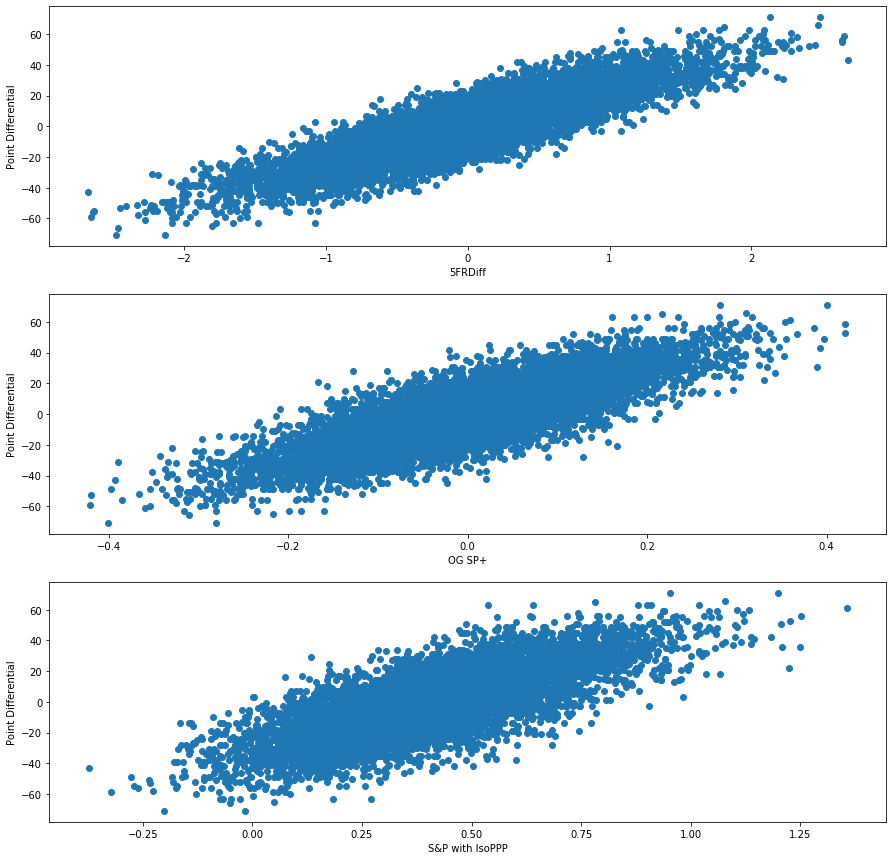

In [17]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [18]:
# fg = px.scatter(stored_game_boxes, x="5FRDiff", y="PtsDiff", trendline="lowess")
# fg.update_layout(
#     title="5FR Margin vs Point Margin (2012-2019)",
#     xaxis_title="5FR Margin",
#     yaxis_title="Point Margin")
# fg.show()

In [19]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.905984,0.739098
S&PIsoPPPDiff,0.905984,1.000000,0.799002
PtsDiff,0.739098,0.799002,1.000000


In [20]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,4.968386,4.842944,4.629272,4.134715,4.968386,4.842944,5.453906,0.617590,0.844447,2.041125
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-4.968386,-4.842944,-4.629272,-4.134715,-4.968386,-4.842944,4.546094,-0.617590,0.844447,2.041125
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,3.471563,2.354973,0.969049,1.381137,3.471563,2.354973,5.207552,0.603619,0.825343,0.194393
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,-3.471563,-2.354973,-0.969049,-1.381137,-3.471563,-2.354973,4.792448,-0.603619,0.825343,0.194393
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,3.498718,3.709156,1.714467,1.340515,3.498718,3.709156,4.744612,-0.351666,0.480841,0.534580


In [21]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [22]:
# outliers

In [23]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,4.968386,4.842944,4.629272,4.134715,4.968386,4.842944,5.453906,0.617590,0.844447,2.041125
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-4.968386,-4.842944,-4.629272,-4.134715,-4.968386,-4.842944,4.546094,-0.617590,0.844447,2.041125
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,3.471563,2.354973,0.969049,1.381137,3.471563,2.354973,5.207552,0.603619,0.825343,0.194393
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,-3.471563,-2.354973,-0.969049,-1.381137,-3.471563,-2.354973,4.792448,-0.603619,0.825343,0.194393
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,3.498718,3.709156,1.714467,1.340515,3.498718,3.709156,4.744612,-0.351666,0.480841,0.534580


In [24]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [25]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)


r_2 = r2_score(test_data["PtsDiff"][:,np.newaxis], preds)
print(f'R-squared: {r_2}')

def adj_r2_score(R, n, p): 
    return 1-(1-R)*(n-1)/(n-p-1)
adj_r2 = adj_r2_score(r_2, len(test_data["PtsDiff"]), 1)
print(f'Adj R-squared: {adj_r2}\n')
    
test.corr()

Linear Regression: y = 24.43046x + -0.03497
Mean Pred Score: -0.5250522969949752
Pred Std Dev: 17.369024703019917
Mean Abs Error: 7.832334025506784
Mdn Abs Error: 6.569753626530084
R-squared: 0.7616553167006361
Adj R-squared: 0.761522163246279



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.738111,0.541572,0.464345,0.772615,0.569564,0.594530,0.984561,0.505043,0.738416,...,0.523905,0.451794,0.059636,0.080853,0.206638,0.206638,0.166660,0.888939,0.872832,0.872832
OffSRDiff,0.738111,1.000000,0.438932,0.254932,0.664437,0.339124,0.395417,0.737769,0.726586,0.669290,...,0.541246,0.421713,0.004917,0.026334,0.161081,0.161081,0.063028,0.903479,0.947671,0.947671
OffERDiff,0.541572,0.438932,1.000000,0.122856,0.469712,0.263822,0.315844,0.533471,0.333307,0.802597,...,0.182247,0.181204,-0.006915,0.005577,0.140169,0.140169,0.056665,0.490997,0.518576,0.518576
FPDiff,0.464345,0.254932,0.122856,1.000000,0.604409,0.054232,0.048564,0.440682,-0.003872,0.181383,...,0.241444,0.241607,0.238947,0.222139,0.244837,0.244837,0.170402,0.554190,0.350333,0.350333
OppRateDiff,0.772615,0.664437,0.469712,0.604409,1.000000,0.138911,0.148739,0.770232,0.229368,0.621220,...,0.482843,0.422346,0.085259,0.109579,0.212300,0.212300,0.226624,0.810330,0.746607,0.746607
OppEffDiff,0.569564,0.339124,0.263822,0.054232,0.138911,1.000000,0.768933,0.571060,0.487374,0.378824,...,0.266827,0.205633,-0.077022,-0.017095,0.081396,0.081396,0.327966,0.445644,0.485671,0.485671
OppPPDDiff,0.594530,0.395417,0.315844,0.048564,0.148739,0.768933,1.000000,0.603832,0.568119,0.431730,...,0.312367,0.224584,-0.037924,-0.006046,0.076950,0.076950,0.031347,0.522838,0.573923,0.573923
PPDDiff,0.984561,0.737769,0.533471,0.440682,0.770232,0.571060,0.603832,1.000000,0.503468,0.730631,...,0.528841,0.447385,0.058170,0.078928,0.216001,0.216001,0.162752,0.883290,0.872923,0.872923
OppSRDiff,0.505043,0.726586,0.333307,-0.003872,0.229368,0.487374,0.568119,0.503468,1.000000,0.504170,...,0.350437,0.248988,-0.040677,-0.000214,0.058932,0.058932,-0.088368,0.638079,0.719244,0.719244
YPPDiff,0.738416,0.669290,0.802597,0.181383,0.621220,0.378824,0.431730,0.730631,0.504170,1.000000,...,0.408386,0.382481,0.005829,0.010384,0.130977,0.130977,0.060841,0.711215,0.750444,0.750444


In [26]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.738528,0.738111,0.671900,0.899894,0.464345,0.498783,0.888939,0.872832,0.872832
ActPts,0.738528,1.000000,0.552381,0.495587,0.657649,0.370580,0.373633,0.665460,0.647176,0.647176
Eff,0.738111,0.552381,1.000000,0.585608,0.767578,0.254932,0.272764,0.903479,0.947671,0.947671
Expl,0.671900,0.495587,0.585608,1.000000,0.643217,0.168777,0.216039,0.641941,0.675861,0.675861
FinDrv,0.899894,0.657649,0.767578,0.643217,1.000000,0.391305,0.435661,0.909197,0.915518,0.915518
FldPos,0.464345,0.370580,0.254932,0.168777,0.391305,1.000000,0.360042,0.554190,0.350333,0.350333
Trnovr,0.498783,0.373633,0.272764,0.216039,0.435661,0.360042,1.000000,0.501669,0.464669,0.464669
5FR,0.888939,0.665460,0.903479,0.641941,0.909197,0.554190,0.501669,1.000000,0.973786,0.973786
5FRDiff,0.872832,0.647176,0.947671,0.675861,0.915518,0.350333,0.464669,0.973786,1.000000,1.000000
PredPtsDiff,0.872832,0.647176,0.947671,0.675861,0.915518,0.350333,0.464669,0.973786,1.000000,1.000000


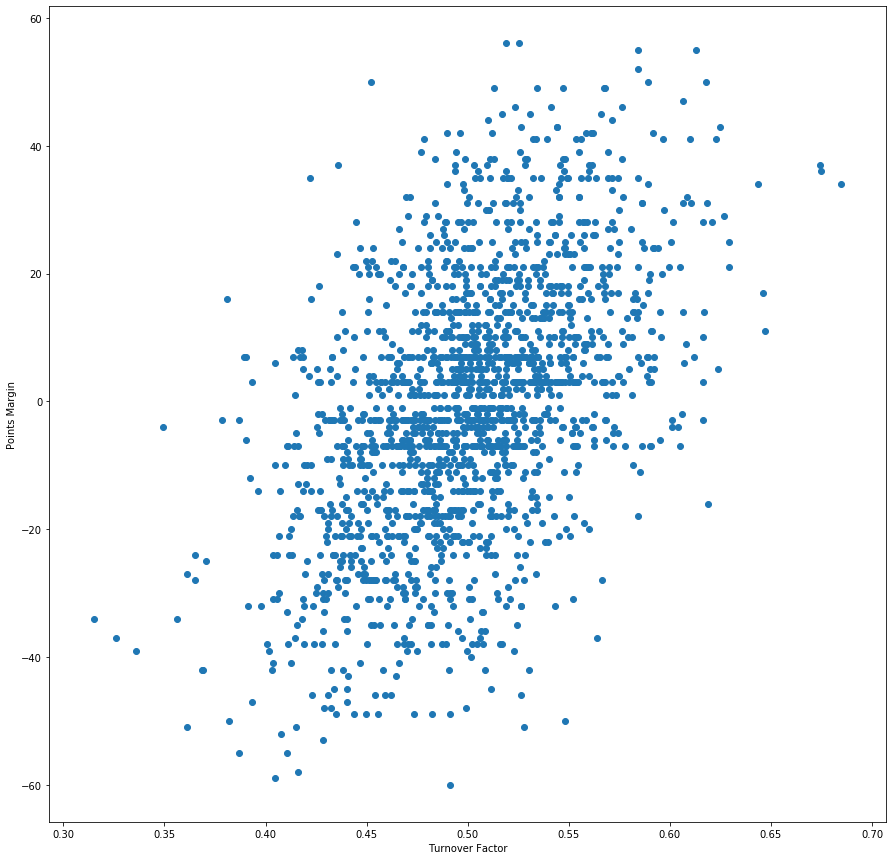

In [27]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

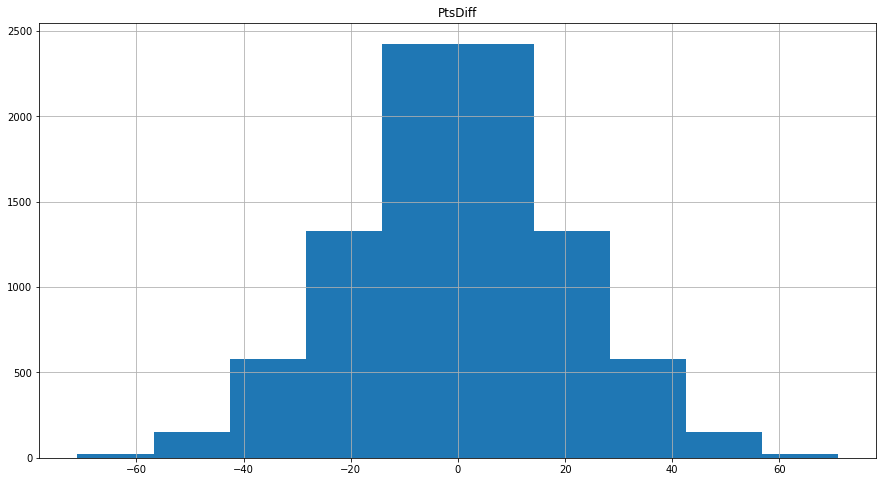

In [28]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

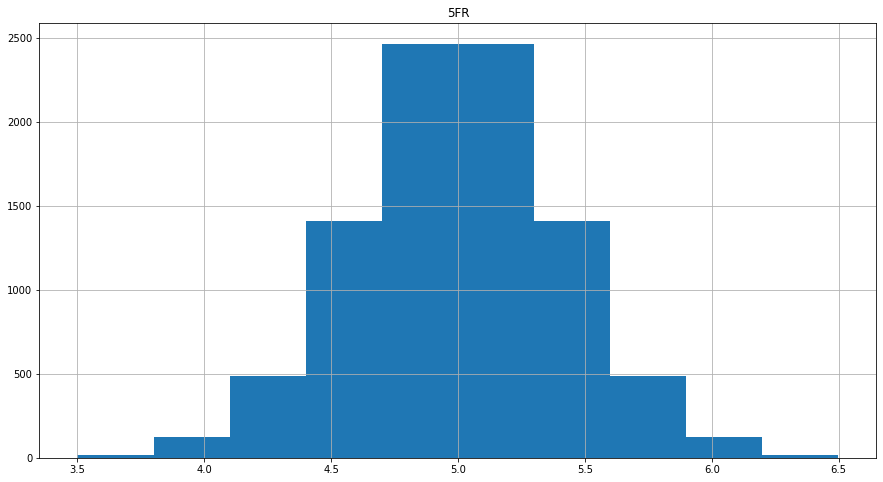

In [29]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

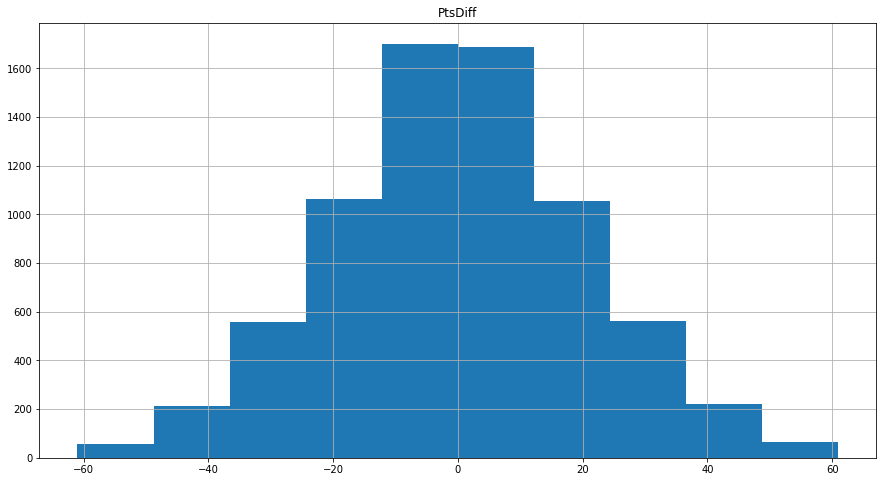

In [30]:
train_data.hist(column='PtsDiff', figsize=(15,8));

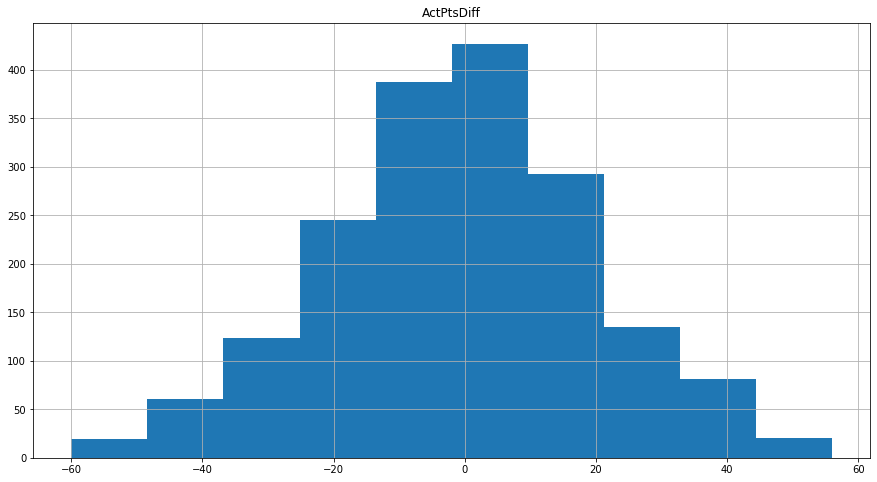

In [31]:
test.hist(column='ActPtsDiff', figsize=(15,8));

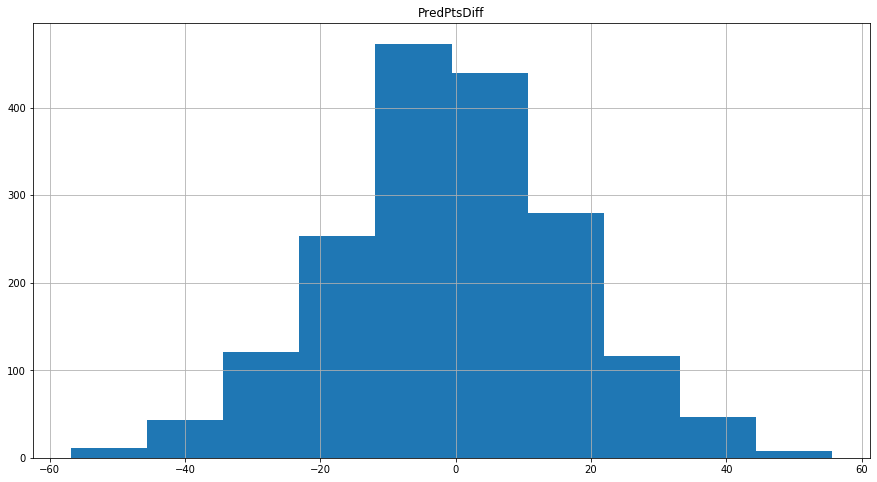

In [32]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [33]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [34]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -3.0 (exact value: -3.4830018253735386)
Z score: -0.17030026607448318
Win Prob for Virginia Tech: 43.24%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.0,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,0.0,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [35]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -12.0 (exact value: -12.225648615865786)
Z score: -0.6736472841124149
Win Prob for Georgia Tech: 25.03%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,-0.121075,0.018689,0.000768,0.0,0.25,0.0,0.0,0.0,4.750502,-0.498995
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,0.121075,-0.018689,-0.000768,0.0,-0.25,0.0,0.0,0.0,5.249498,0.498995


In [36]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -1.0 (exact value: -0.6513666642957218)
Z score: -0.007272392633466893
Win Prob for Georgia Tech: 49.71%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.300725,0.012719,0.0,0.066667,0.166667,0.0,0.0,1.0,5.012615,0.025231
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.300725,-0.012719,0.0,-0.066667,-0.166667,0.0,0.0,-1.0,4.987385,-0.025231


In [37]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 4.0 (exact value: 3.7636319098608126)
Z score: 0.24691566050396155
Win Prob for Mississippi State: 59.75%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.070423,5.563380,0.880173,...,0.092249,0.000243,-0.004614,-0.666667,-0.083333,-0.2,-0.2,0,4.922257,-0.155486
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,-0.092249,-0.000243,0.004614,0.666667,0.083333,0.2,0.2,0,5.077743,0.155486


In [38]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -5.0 (exact value: -5.4078997601991965)
Z score: -0.2811238711840424
Win Prob for Texas A&M: 38.93%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,-0.349878,0.001282,-0.047436,0.2,-0.2,-0.25,-0.25,-0.25,5.109964,0.219927
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,0.349878,-0.001282,0.047436,-0.2,0.2,0.25,0.25,0.25,4.890036,-0.219927


In [39]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.956361,13,12.0,1.0
2,LSU,0.950945,13,12.0,1.0
3,Alabama,0.928878,12,11.0,1.0
4,Oklahoma,0.898727,13,12.0,1.0
5,Clemson,0.897048,13,12.0,1.0
6,Navy,0.858305,12,10.0,2.0
7,Utah,0.854714,13,11.0,2.0
8,Buffalo,0.838139,12,10.0,2.0
9,Oregon,0.829202,13,11.0,2.0
10,Minnesota,0.822119,12,10.0,2.0


In [40]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,10.743596,2.256404
53,LSU,9.958929,3.041071
78,Oklahoma,9.068622,3.931378
115,Utah,8.337407,4.662593
34,Georgia,7.625216,5.374784
11,Baylor,7.433842,5.566158
82,Oregon,7.272460,5.727540
3,Appalachian State,7.236396,5.763604
56,Memphis,7.236283,5.763717
91,SMU,6.948806,5.051194


In [41]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Florida State,2012,5.540727,1
1,Arizona State,2012,5.441691,2
2,Alabama,2012,5.356451,3
3,Boise State,2012,5.354934,4
4,Fresno State,2012,5.315534,5
5,Georgia,2012,5.315359,6
6,Oklahoma,2012,5.280176,7
7,Bowling Green,2012,5.256537,8
8,Ohio State,2012,5.254690,9
9,Northern Illinois,2012,5.225756,10


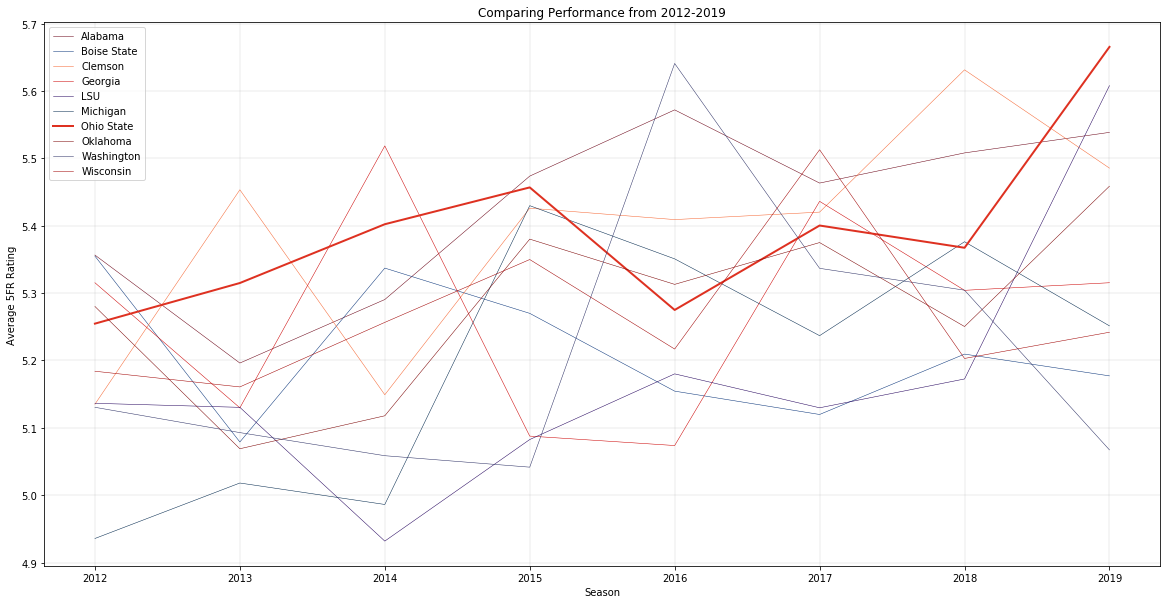

In [42]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [43]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

,Team,Avg5FR
0,Alabama,5.424796
1,Ohio State,5.392066
2,Clemson,5.388699
3,Oklahoma,5.280533
4,Georgia,5.272604
5,Wisconsin,5.265736
6,Boise State,5.212769
7,Washington,5.209143
8,Michigan,5.198177
9,Western Kentucky,5.196342


In [44]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

,Team,Season,5FR,Rank
125,Florida State,2013,5.684449,1
896,Ohio State,2019,5.665306,1
508,Washington,2016,5.640725,1
766,Clemson,2018,5.631292,1
897,LSU,2019,5.607877,2
509,Alabama,2016,5.571865,2
767,NC State,2018,5.544967,2
0,Florida State,2012,5.540727,1
898,Alabama,2019,5.538494,3
252,TCU,2014,5.520033,1


In [45]:
strength_max[strength_max.Team == "Georgia Tech"]

,Team,Season,5FR,Rank
281,Georgia Tech,2014,5.147855,30
708,Georgia Tech,2017,4.981531,73
69,Georgia Tech,2012,4.963736,70
200,Georgia Tech,2013,4.945748,76
580,Georgia Tech,2016,4.935661,73
475,Georgia Tech,2015,4.815974,96
872,Georgia Tech,2018,4.773704,107
1002,Georgia Tech,2019,4.761505,107


In [46]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322872751.0,Wyoming,2012.0,Air Force,4.0
4,322942005.0,New Mexico,2012.0,Air Force,5.0
5,323290278.0,Fresno State,2012.0,Air Force,6.0
6,332502005.0,Utah State,2013.0,Air Force,1.0
7,332642005.0,Wyoming,2013.0,Air Force,2.0
8,332712440.0,Nevada,2013.0,Air Force,3.0
9,332782426.0,Navy,2013.0,Air Force,4.0


In [ ]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4, adjust_hfa = False):
    considered_weeks = week
    if (week <= 0):
        considered_weeks = 16 # consider all weeks
    
    applied_year = year
    if (week == 0):
        applied_year = applied_year - 1 
        
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == applied_year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == applied_year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    fcs_talent = calculate_fcs_talent(year)
    fcs_old_talent = calculate_fcs_talent(applied_year)
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    # Generate comparison attributes for team 1
    team1_talent = fcs_talent
    team1_old_talent = fcs_old_talent
    team1_avg_ffr = grouped_by_year.get_group((team1, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team1, applied_year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_talent = fcs_talent
        team1_old_talent = fcs_old_talent
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_talent = calculate_roster_talent(team1, year)
        team1_old_talent = calculate_roster_talent(team1, applied_year)
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_talent = fcs_talent
    team2_old_talent = fcs_old_talent
    team2_avg_ffr = grouped_by_year.get_group((team2, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team2, applied_year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
#         print("fcs")
        team2_talent = fcs_talent
        team2_old_talent = fcs_old_talent
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_talent = calculate_roster_talent(team2, year)
        team2_old_talent = calculate_roster_talent(team2, applied_year)
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()
    
#     print("checker")
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
        
    if (week == 0):
        # adjust by team talent    
#         if (team2_talent < team1_talent):
#             team2_avg_ffr *= (team2_talent / team1_talent)
#         elif (team2_talent > team1_talent):
#             team1_avg_ffr *= (team1_talent / team2_talent)
        
        # adjust by returning production
        team1_avg_ffr *= (team1_talent / team1_old_talent)
        team2_avg_ffr *= (team2_talent / team2_old_talent)
#         print("preseason")
#         print(team1, team1_talent)
#         print(team2, team2_talent)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    
    proj_MOV = pred[0]
    if (adjust_hfa):
        proj_MOV += 2.5
    z = (proj_MOV - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, proj_MOV]

predict_matchup('Georgia Tech', 'Clemson', 2020, 0, -1, True)

In [48]:
team_triples = [
    ['Buffalo', 'Charlotte', 7, 24], # Buff 31, Char 9
    ['Utah State', 'Kent State', 7, -10], # Kent 51, Utah 41
    ['San Diego State', 'Central Michigan', 3.5, 37], # SDSU 48, CMU 11
    ['Georgia Southern','Liberty', 4.5, -7], # Lib 23, GASO 16
    ['SMU','Florida Atlantic', 7, -14], # FAU 52, SMU 28
    ['Florida International','Arkansas State', 1, -6], # ArkSt 34, FIU 28
    ['Washington', 'Boise State', 3.5, 31], # Wash 38, Boise 7
    ['Appalachian State', 'UAB', 17, 14], # App 31, UAB 17
    ['UCF','Marshall',15,23], # UCF 48, Marshall 25
    ['BYU',"Hawai'i",2,-4], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
    ['Miami','Louisiana Tech',6,-14], # LaTech 14, Miami 0
    ['Pittsburgh','Eastern Michigan',11, 4], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
    ['North Carolina','Temple',5, 42], # UNC 55, Temple 13
    ['Michigan State','Wake Forest',3.5,6], # MichSt 27, Wake 21
    ['Texas A&M', 'Oklahoma State', 7, 3], # TAMU 24, OKST 21
    ['Iowa', 'USC', 2.5, 24], # Iowa 48, USC 24
    ['Air Force', 'Washington State', 3, 10], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
    ['Penn State','Memphis',7,14], # Cotton Bowl - PennSt 53, Memphis 39
    ['Notre Dame', 'Iowa State', 4, 24], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
    ['LSU','Oklahoma',11, 35], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
    ['Clemson','Ohio State',2.5, 6], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
    ['Western Kentucky', 'Western Michigan', 3.5, 3], # WKU 23, WMU 20
    ['Mississippi State', 'Louisville', 4, -10], # LOU 38, MSST 28
    ['California', 'Illinois', 6.5, 15], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
    ['Florida','Virginia',14, 8], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
    ['Virginia Tech', 'Kentucky', 3, -7], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
    ['Arizona State', 'Florida State', 4, 6], # ASU 20, FSU 14
#    ----- 19-8 SU / 14-13 ATS ------  
    ['Navy', 'Kansas State', 2, 3], # Navy 20, Kansas St 17
#    ----- 20-8 SU / 15-13 ATS ------  
    ['Wyoming', 'Georgia State', 7, 21], # Wyoming 38, GAST 17
#    ----- 21-8 SU / 15-14 ATS ------  
    ['Utah', 'Texas', 7, -18], # Texas 38, Utah 10
#    ----- 21-9 SU / 16-14 ATS ------     
    ['Auburn', 'Minnesota', 7.5, -7], # Minnesota 31, Auburn 24
    ['Alabama', 'Michigan', 7, 19], # Bama 35, Mich 16
#    ----- 23-9 SU / 17-15 ATS ------    
    ['Wisconsin','Oregon',2.5, -1], # Rose Bowl - Oregon 28, Wisc 27
#    ----- 23-10 SU / 18-15 ATS ------  
    ['Georgia','Baylor',7.5, 12], # Sugar Bowl - uga 26, Baylor 14
#    ----- 23-11 SU / 18-16 ATS ------      
    ['Cincinnati', 'Boston College',7, 32], # Cincy 38, BC 6
#    ----- 23-12 SU / 18-17 ATS ------    
    ['Tennessee', 'Indiana', 1.5, 1], # Tennessee 23, Indiana 22
#    ----- 23-13 SU / 19-17 ATS ------        
    ['Ohio', 'Nevada', 7.5, 8], # Ohio 30, Nevada 21
#    ----- 24-13 SU / 19-18 ATS ------     
    ['Tulane', 'Southern Mississippi', 7, 17], # Tulane 30, Southern Miss 13
#    ----- 24-14 SU / 19-19 ATS ------     
    ['Louisiana', 'Miami (OH)', 14, 10], # Louisiana 27, Miami 17
#    ----- 24-15 SU / 19-20 ATS ------  
    ["LSU", "Clemson", 6, 17]
#    ----- 24-16 SU / 19-21 ATS ------  
]

def determine_ml_base_win(row):
    winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

def determine_ats_base_win(row):
    mov = row.home_point_diff
    if (row.spread > 0):
        if (mov == row.spread):
            return "Push"
        winner = row.favorite if (mov > row.spread) else row.opponent
    elif (row.spread < 0):
        if (mov == row.spread):
            return "Push"
        winner = row.opponent if (mov < row.spread) else row.favorite
    else:
        winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    point_diff = data[3]
    predictor = predict_matchup(team1, team2, 2019, -1, 4, False)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "home_point_diff" : [point_diff],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets['ml_win'] = bets.apply(lambda x: determine_ml_base_win(x), axis=1) 
bets['ats_win'] = bets.apply(lambda x: determine_ats_base_win(x), axis=1) 
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,home_point_diff,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick,ml_win,ats_win
0,Buffalo,Charlotte,7.0,24,4.608498,0.616216,False,Buffalo,Charlotte,Buffalo,Buffalo
0,Utah State,Kent State,7.0,-10,4.235572,0.607991,False,Utah State,Kent State,Kent State,Kent State
0,San Diego State,Central Michigan,3.5,37,-0.747171,0.494898,False,Central Michigan,Central Michigan,San Diego State,San Diego State
0,Georgia Southern,Liberty,4.5,-7,5.241584,0.630058,True,Georgia Southern,Georgia Southern,Liberty,Liberty
0,SMU,Florida Atlantic,7.0,-14,-11.535899,0.263061,False,Florida Atlantic,Florida Atlantic,Florida Atlantic,Florida Atlantic
0,Florida International,Arkansas State,1.0,-6,-7.679415,0.340205,False,Arkansas State,Arkansas State,Arkansas State,Arkansas State
0,Washington,Boise State,3.5,31,0.229482,0.517325,False,Washington,Boise State,Washington,Washington
0,Appalachian State,UAB,17.0,14,10.440066,0.736079,False,Appalachian State,UAB,Appalachian State,UAB
0,UCF,Marshall,15.0,23,7.273638,0.673284,False,UCF,Marshall,UCF,UCF
0,BYU,Hawai'i,2.0,-4,0.153867,0.515590,False,BYU,Hawai'i,Hawai'i,Hawai'i


In [49]:
print(f"ATS Record: {len(bets[bets.ats_pick == bets.ats_win])}-{len(bets[bets.ats_pick != bets.ats_win])}")
print(f"ML Record: {len(bets[bets.ml_pick == bets.ml_win])}-{len(bets[bets.ml_pick != bets.ml_win])}")

ATS Record: 20-20
ML Record: 25-15


In [50]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 0.0 (exact value: 0.26314986357880293)
Z score: 0.04537975931583165
Win Prob for Virginia: 51.81%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,-0.403644,-0.089435,-0.044717,0.25,-0.232143,0.333333,0.333333,0.0,4.993899,-0.012203
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,0.403644,0.089435,0.044717,-0.25,0.232143,-0.333333,-0.333333,0.0,5.006101,0.012203


In [51]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 11.287193307041658)
Z score: 0.6800753528770594
Win Prob for North Carolina: 75.18%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.235394,0.079888,0.037736,0.238095,0.095238,-0.214286,-0.214286,0.5,5.231722,0.463445
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.235394,-0.079888,-0.037736,-0.238095,-0.095238,0.214286,0.214286,-0.5,4.768278,-0.463445


In [52]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 20.0 (exact value: 20.45350188782526)
Z score: 1.2078141716945534
Win Prob for Pittsburgh: 88.64%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,-0.248736,0.038746,0.026324,0.0,-1.0,-0.25,-0.25,0.166667,5.419322,0.838645
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,0.248736,-0.038746,-0.026324,0.0,1.0,0.25,0.25,-0.166667,4.580678,-0.838645


In [53]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -10.0 (exact value: -10.467385367775877)
Z score: -0.5724174638920427
Win Prob for Auburn: 28.35%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,-0.083465,-0.033763,-0.013333,-0.321429,-0.196429,-0.333333,-0.333333,-0.5,5.213512,0.427025
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,0.083465,0.033763,0.013333,0.321429,0.196429,0.333333,0.333333,0.5,4.786488,-0.427025


In [54]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 37.0 (exact value: 36.72665470107597)
Z score: 2.1447207102880146
Win Prob for Georgia: 98.40%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,0.455922,0.020115,0.003352,0.888889,-0.888889,0.615385,0.615385,0.5,5.752373,1.504745
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,-0.455922,-0.020115,-0.003352,-0.888889,0.888889,-0.615385,-0.615385,-0.5,4.247627,-1.504745


In [55]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 23.0 (exact value: 23.235915930334187)
Z score: 1.3680082004372929
Win Prob for Clemson: 91.43%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 10.0 (exact value: 10.193518727932352)
Z score: 0.6171083988995485
Win Prob for Georgia Tech: 73.14%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -11.0 (exact value: -11.358722919714477)
Z score: -0.6237351151234113
Win Prob for The Citadel: 26.64%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 22.0 (exact value: 22.408614193195245)
Z score: 1.3203773316185559
Win Prob for Temple: 90.66%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 11.287193307041658)
Z score: 0.6800753528

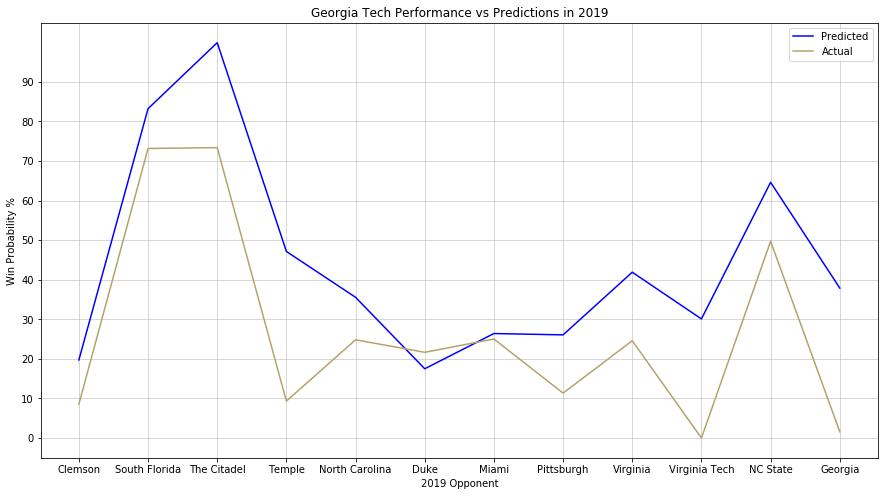

In [56]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

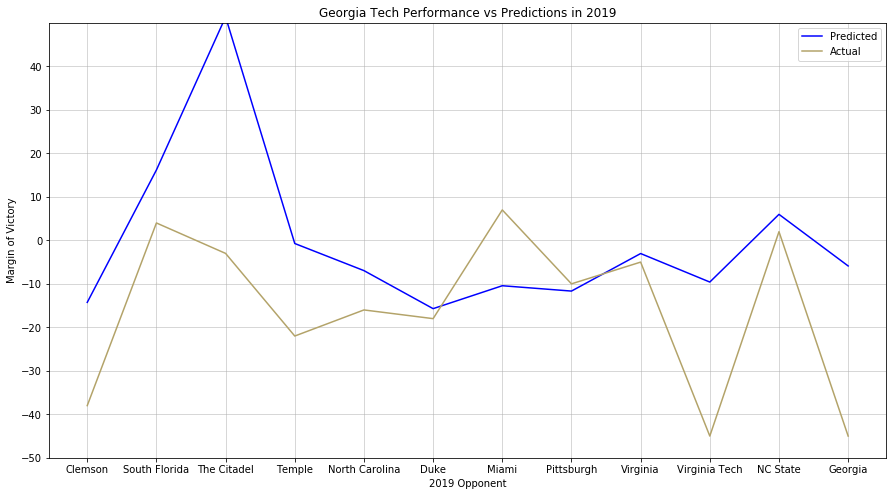

In [57]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 43.0 (exact value: 43.14777048838087)
Z score: 2.5144084674934306
Win Prob for Georgia Tech: 99.40%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 9.0 (exact value: 8.86660648877302)
Z score: 0.5407130766608378
Win Prob for South Florida: 70.56%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 8.0 (exact value: 7.6705935315545215)
Z score: 0.4718541178149477
Win Prob for Pittsburgh: 68.15%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 37.0 (exact value: 37.32920523539346)
Z score: 2.1794118080681177
Win Prob for Clemson: 98.53%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 41.0 (exact value: 41.32159396490978)
Z score:

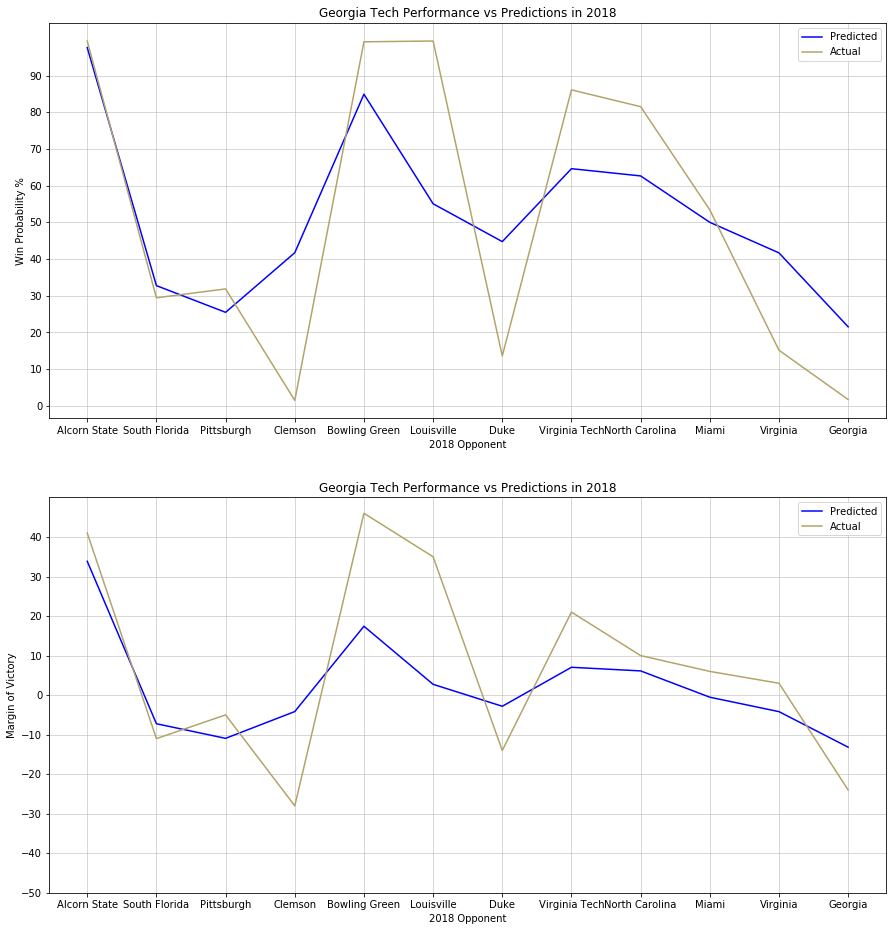

In [58]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

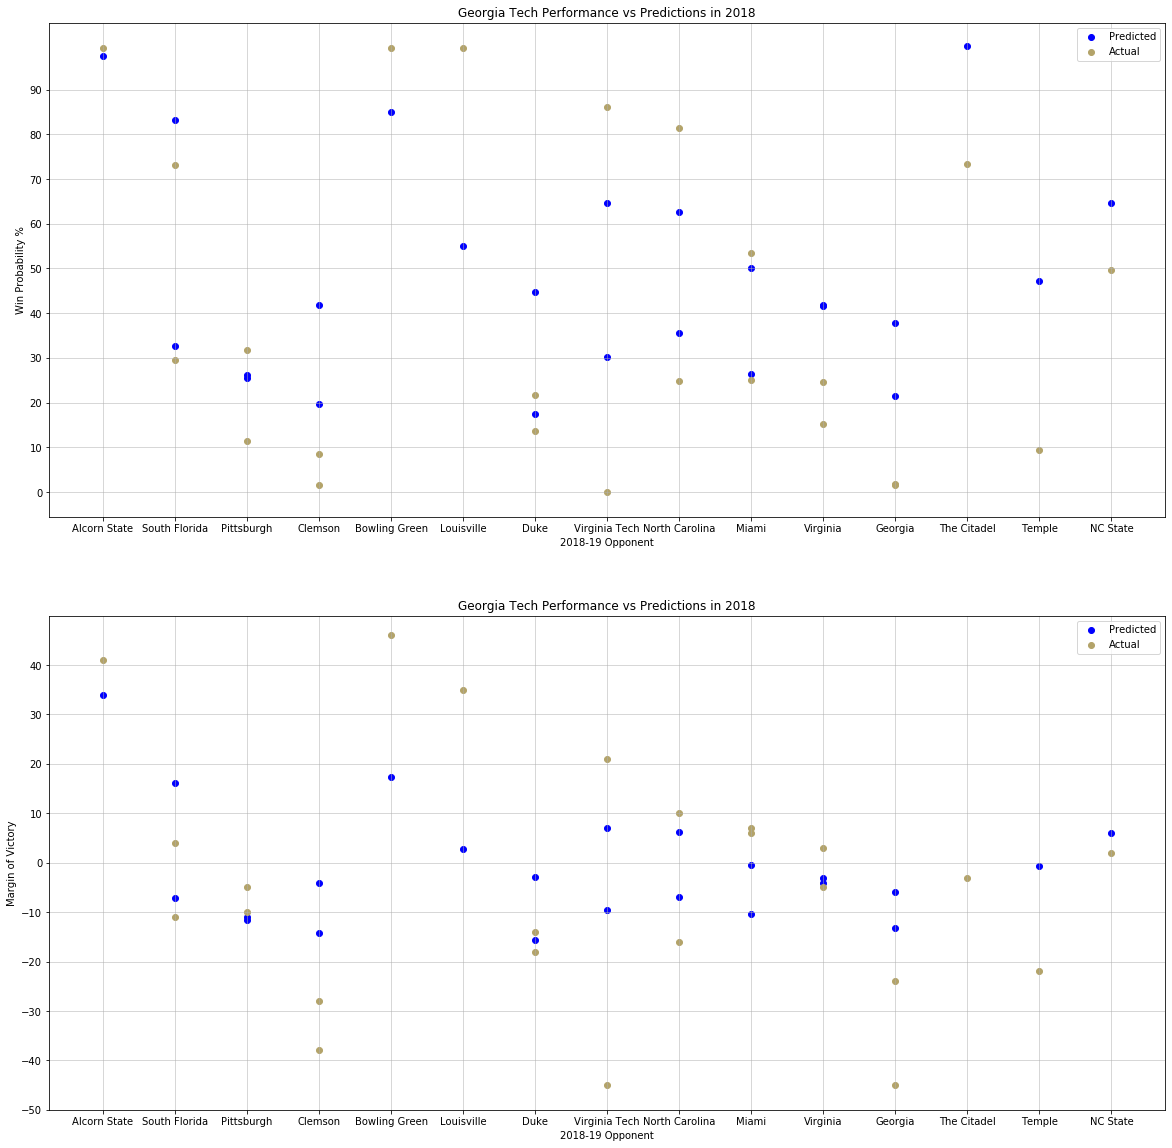

In [59]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [60]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019
Season,,,,,,,,
2012,1.000000,0.626725,0.448751,0.362623,0.297071,0.240737,0.211881,0.348007
2013,0.626725,1.000000,0.478699,0.326866,0.191959,0.235060,0.138107,0.309027
2014,0.448751,0.478699,1.000000,0.481970,0.314802,0.250626,0.248098,0.263857
2015,0.362623,0.326866,0.481970,1.000000,0.550852,0.428865,0.277751,0.334994
2016,0.297071,0.191959,0.314802,0.550852,1.000000,0.453697,0.307218,0.475054
2017,0.240737,0.235060,0.250626,0.428865,0.453697,1.000000,0.552898,0.399776
2018,0.211881,0.138107,0.248098,0.277751,0.307218,0.552898,1.000000,0.478004
2019,0.348007,0.309027,0.263857,0.334994,0.475054,0.399776,0.478004,1.000000


In [61]:
def clean_prediction_prob_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    prob = predict_matchup(home_team, away_team, row.Year, 0, -1,(row.Site != "Neutral"))[0]
    if (row.Team == home_team):
        return prob
    else:
        return 1-prob

def clean_prediction_mov_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    mov = predict_matchup(home_team, away_team, row.Year, 0, -1, (row.Site != "Neutral"))[1]
    if (row.Team == home_team):
        return mov
    else:
        return -1 * mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame

opp_2020_df = pd.DataFrame(data={
    "Team" : ["Clemson","Gardner-Webb","UCF","North Carolina","Virginia Tech","Virginia","Pittsburgh","Syracuse","Duke","Notre Dame","Miami","Georgia"],
    "Site" : ["Home","Home","Home","Away","Away","Home","Away","Away","Home","Neutral","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("Georgia Tech", opp_2020_df, 2020)
georgia_tech_2020

,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,Georgia Tech,Clemson,Home,11.061043,-21.772376
1,2020,Georgia Tech,Gardner-Webb,Home,99.960187,57.732262
2,2020,Georgia Tech,UCF,Home,44.858647,-2.769711
3,2020,Georgia Tech,North Carolina,Away,22.105868,-12.825174
4,2020,Georgia Tech,Virginia Tech,Away,25.750809,-10.782998
5,2020,Georgia Tech,Virginia,Home,40.238382,-4.818357
6,2020,Georgia Tech,Pittsburgh,Away,29.164895,-9.003141
7,2020,Georgia Tech,Syracuse,Away,39.426975,-4.133453
8,2020,Georgia Tech,Duke,Home,49.028833,-0.947918
9,2020,Georgia Tech,Notre Dame,Neutral,23.197036,-13.245663


In [62]:
generate_win_prob(401135288, 2019)
box2 = calculate_box_score(401135288, 2019)
# testDiffs = ["Team",'5FRDiff']
# print(box2[["Team","FP","FPDiff"]])
break_down_box_score(box2)

Could not find basic game data for game_id 401135288 locally, checking CFB Data API
Could not find drive data for game_id 401135288 locally, checking CFB Data API
Could not find play by play data for game_id 401135288 locally, checking CFB Data API
Game: Oregon @ Wisconsin
Actual Winner: Oregon
MOV: Oregon by 1
Proj MOV: Oregon by 4.0 (exact value: 4.32713391395265)
Z score: 0.2793585877106839
Win Prob for Oregon: 61.00%
---
Could not find basic game data for game_id 401135288 locally, checking CFB Data API
Could not find drive data for game_id 401135288 locally, checking CFB Data API
Could not find play by play data for game_id 401135288 locally, checking CFB Data API


,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Oregon,5.114379,4.961943,4.87236,5.115385,5.68268,5.089276,0.178552
1,Wisconsin,4.885621,5.038057,5.12764,4.884615,4.31732,4.910724,-0.178552


In [63]:
predict_matchup("Oregon","Wisconsin", 2012, -1)

[0.5173255540251067, 0.22949954556958146]

In [64]:
line_data = pd.DataFrame()

for i in range(2013, 2020):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")

Spreads imported: 17274


In [65]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite))[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite))[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    selected_games = games[(games.id.isin(lines.id))]
    lines = pd.merge(lines, selected_games[['id','neutral_site']], on="id")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam,"AwayScore": lines.awayScore,"NeutralSite":lines.neutral_site,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [66]:
historic_validation = pd.DataFrame()
for i in range(2013, 2020):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 535 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 530 games with betting lines for 2013 season.
[Simulation] Creating projections for 530 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 528 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 488 games with betting lines for 2014 season.
[Simulation] Creating projections for 488 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 570 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 542 games with betting lines for 2015 season.
[Simulation] Creating projections for 542 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

KeyboardInterrupt: 

In [ ]:
def generate_weekly_payout(x, bet_cash):
    avg_games = (x.W + x.L + x.D) / max(games[(games.season == x.season)].week)
    wins = avg_games * x.WinPct
    losses = avg_games * (1 - x.WinPct - verify_division(x.D, (x.W + x.L + x.D)))
    payout = (bet_cash * wins) - ((bet_amount * 1.1) * losses)
    return payout

ats_payout = historic_validation[(historic_validation.pick_category == "ATS")].copy()
bet_amount = 5
ats_payout['total_invested'] = ats_payout.apply(lambda x: bet_amount * (x.W + x.L + x.D), axis=1)
ats_payout['net_payout'] = ats_payout.apply(lambda x: (bet_amount * x.W) - ((bet_amount * 1.1) * x.L), axis=1)
ats_payout['avg_weekly_payout'] = ats_payout.apply(lambda x: generate_weekly_payout(x, bet_amount), axis=1)
ats_payout['pct_return'] = ats_payout.apply(lambda x: (x.net_payout / x.total_invested), axis=1)
print(f"Total earnings (2013-2019) if betting ${bet_amount} per game: ${sum(round(ats_payout.net_payout))}")
ats_payout

In [ ]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

In [ ]:
f, a = plt.subplots(1, figsize=(15, 8))
a.plot(historic_validation[(historic_validation.pick_category == "ML")].season, historic_validation[(historic_validation.pick_category == "ML")].WinPct, color='#B3a369', label="ML")
a.plot(historic_validation[(historic_validation.pick_category == "ATS")].season, historic_validation[(historic_validation.pick_category == "ATS")].WinPct, color='#003057', label="ATS")
a.set_title("Betting Performance")
a.grid(linestyle='-', linewidth=0.5)
a.set_xlabel('Season');
a.set_ylabel('Win Percentage');
a.legend();

# import plotly.graph_objects as go

# # fg = px.line(historic_validation, x="season", y="WinPct", color='pick_category')
# # fg.show()

# fg = go.Figure()
# fg.add_trace(go.Scatter(x=historic_validation[(historic_validation.pick_category == "ML")].season, y=historic_validation[(historic_validation.pick_category == "ML")].WinPct * 100,
#                     mode='lines+markers',
#                     name='ML', line=dict(color='#b3a369')))
# fg.add_trace(go.Scatter(x=historic_validation[(historic_validation.pick_category == "ATS")].season, y=historic_validation[(historic_validation.pick_category == "ATS")].WinPct * 100,
#                     mode='lines+markers',
#                     name='ATS', line=dict(color='#003057')))
# fg.layout.xaxis.title = "Season"
# fg.layout.yaxis.title = "Win Percentage"
# fg.layout.title = "Betting Performance"

# fg.show()


In [ ]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [ ]:
predict_matchup("LSU", "Clemson", 2019, week = -1, games_to_consider = 4, adjust_hfa = True)

In [ ]:
generate_win_prob(401135295, 2019)

In [ ]:
# Rankings data

rank_data = pd.DataFrame()

for i in range(2012, 2020):
    ln = retrieveCfbDataFile('rankings',i)
    ln['year'] = i
    rank_data = rank_data.append(ln, sort=False)
    
print(f"Rankings imported: {len(rank_data)}")

def fix_ranking_name(poll):
    if ((poll == "Playoff Committee Rankings") | (poll == "BCS Standings")):
        return "BCS/CFP"
    elif (poll == "Coaches Poll"):
        return "Coaches"
    elif (poll == "AP Top 25"):
        return "AP"
    else:
        return "Unknown"
    
rank_data.poll = rank_data.poll.apply(lambda x: fix_ranking_name(x))
    
def retrieve_rank(x, title, week):
    r = rank_data[(rank_data.school == x.Team) & (rank_data.poll == title) & (x.Season == rank_data.season) & (rank_data.week == week)]
    if len(r) == 0:
        return None
    return stringify_entry(r['rank'])

org_season = stored_game_boxes.copy().groupby(['Team','Season'])
org_ratings = org_season.apply(lambda x: x['5FRDiff'].mean())
org_fr_year = org_ratings.reset_index()
org_fr_year.columns = ["Team",'Season','5FRDiff']
org_fr_year

org_tmp = org_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FRDiff', ascending=False)).reset_index(drop=True)

In [ ]:
def create_srs_for_year(season):
    terms = []
    solutions = []
    
    participants = opponent_game_ids[(opponent_game_ids.Season == season)].Team.drop_duplicates()
#     participants = participants.apply(lambda x: "San Jose State" if (x == "San JosÃÂÃÂ© State") else x)
    participants = participants.to_list()
#     print(participants)
    for team in participants:
        row = []
        # get a list of team opponents
        opps = opponent_game_ids[(opponent_game_ids.Team == team) & (opponent_game_ids.Season == season)].Opponent.to_list()

        for opp in participants:
            if opp == team:
                # coefficient for the team should be 1
                row.append(1)
            elif opp in opps:
                # coefficient for opponents should be 1 over the number of opponents
                row.append(-1.0/len(opps))
            else:
                # teams not faced get a coefficient of 0
                row.append(0)

        terms.append(row)

        # average game spread on the other side of the equation
        solutions.append(org_tmp[(org_tmp.Team == team) & (org_tmp.Season == season)]['5FRDiff'].mean())

    slns = np.linalg.solve(np.array(terms), np.array(solutions))
    ratings = list(zip( participants, slns ))
    srs = pd.DataFrame(ratings, columns=['Team', '5FRSRS'])
    srs.sort_values(by='5FRSRS', ascending=False, inplace=True)
    srs['5FRSRSRank'] = range(1, len(srs)+1)
    return srs

gen_srs = create_srs_for_year(2019)
gen_srs

In [ ]:
# def adjust_rating(row):
#     # adjust by opps, conf
#     # figure out how much better or worse the team's schedule was than average
#     # figure out how much better or worse the team's schedule was than its conference's schedules
#     natl_avg = org_tmp[(org_tmp.Season == row.Season)]['5FRDiff'].mean()
#     opps = opponent_game_ids[(opponent_game_ids.Team == row.Team) & (opponent_game_ids.Season == row.Season)].Opponent.to_list()
#     opp_avg = org_tmp[(org_tmp.Season == row.Season) & (org_tmp.Team.isin(opps))]['5FRDiff'].mean()
#     team_conf = teams[(teams.school == row.Team)].conference.to_list()
#     opp_conf_avg = natl_avg
#     if (len(team_conf) > 0):
#         opp_conf = teams[(teams.conference.isin(team_conf))].school.to_list()
#         opp_conf_avg = org_tmp[(org_tmp.Season == row.Season) & (org_tmp.Team.isin(opp_conf))]['5FRDiff'].mean()
    
#     opp_diff = (opp_avg - natl_avg) / natl_avg
#     conf_diff = (opp_conf_avg - natl_avg) / natl_avg
    
#     return row['5FRDiff'] * opp_diff * conf_diff
    

# org_tmp['Adj5FRDiff'] = org_tmp.apply(lambda x: adjust_rating(x), axis=1)
# org_tmp.sort_values(by='Adj5FRDiff', ascending=False)

In [ ]:
org_team_strength = pd.DataFrame()
def retrieve_srs(x, srs_data):
    r = srs_data[(srs_data.Team == x.Team)]
    if len(r) == 0:
        return None
    return stringify_entry(r['5FRSRS'])
def retrieve_srs_rank(x, srs_data):
    r = srs_data[(srs_data.Team == x.Team)]
    if len(r) == 0:
        return None
    return stringify_entry(r['5FRSRSRank'])

for yr in range(2012, 2020):
    srs = create_srs_for_year(yr)
    retrieve = org_tmp[org_tmp.Season == yr].copy()
    retrieve['5FRRank'] = range(1, len(retrieve)+1)
    max_week = rank_data[rank_data.season == yr].week.max()
    retrieve['5FRSRS'] = retrieve.apply(lambda x: retrieve_srs(x, srs), axis=1)
    retrieve['5FRSRSRank'] = retrieve.apply(lambda x: retrieve_srs_rank(x, srs), axis=1)
    retrieve['AP'] = retrieve.apply(lambda x: retrieve_rank(x, "AP",max_week), axis=1)
    retrieve['Coaches'] = retrieve.apply(lambda x: retrieve_rank(x, "Coaches",max_week), axis=1)
    retrieve['BCS/CFP'] = retrieve.apply(lambda x: retrieve_rank(x, "BCS/CFP",max_week), axis=1)
    org_team_strength = org_team_strength.append(retrieve)
print(org_team_strength[org_team_strength['5FRSRS'].isna() == True])    

org_team_strength['5FRPerf'] = model.predict(org_team_strength['5FRSRS'][:,np.newaxis]) 
org_team_strength['5FRRank'] = org_team_strength['5FRRank'].apply(lambda y: None if (y > 25) else y)
org_team_strength['5FRSRSRank'] = org_team_strength['5FRSRSRank'].apply(lambda y: None if (y > 25) else y)
org_team_strength

In [ ]:
def retrieve_rankings_chart(team):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Rank')
    
    team_info = teams[teams.school == team]
    school_rankings = org_team_strength[(org_team_strength.Team == team)]
    ax.set_ylim((25, 0))
    ax.set_xlim((2012, 2019))
    ax.plot(school_rankings.Season, school_rankings['5FRSRSRank'], color=stringify_entry(team_info.color),label="5FR", marker='o')
    ax.plot(school_rankings.Season, school_rankings.Coaches, color='b',label="Coaches", marker='o')
    ax.plot(school_rankings.Season, school_rankings.AP, color='red',label="AP", marker='o')
    ax.plot(school_rankings.Season, school_rankings['BCS/CFP'], color='gold',label="BCS/CFP", marker='o')
    ax.set_title(f"{team} Ranking Performance Comparison {school_rankings.Season.min()}-{school_rankings.Season.max()}")
    ax.legend()
    return ax
retrieve_rankings_chart("Clemson");